In [5]:
import sys
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from heapq import nlargest
plt.style.use('ggplot') 
%matplotlib inlineimport sys
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

plt.style.use('ggplot') 
%matplotlib inline

UsageError: unrecognized arguments: sys


# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate chart data for the first 24hrs of a patients icu stay as well as demographic data for patients diagnosed with sepsis according to the Angus criteria. 
(Angus et al, 2001. Epidemiology of severe sepsis in the United States; http://www.ncbi.nlm.nih.gov/pubmed/11445675 )

The query was exported from Porticoto the file CHART_EVENTS_ANGUS_FIRST24.csv. The data was read into a pandas dataframe lab_events. 


In [7]:
print "importing chart data"
data = pd.DataFrame.from_csv('CHART_EVENTS_FIRST24.csv')
print "converting date-time data"
data.loc[:,'charttime']  = pd.to_datetime(data.loc[:,'charttime'])
data.head()  
print "complete"

importing chart data
converting date-time data
complete


## Reorganizing the data
The imported data uses subject_id as the index. The following code moves the subject_id data to a column, creates
a proper index and reorganizes the columns to have the lab results grouped together. 

In [8]:
data['subject_id'] = data.index
data.set_index(np.arange(data.shape[0]), inplace = True)
cols = list(data.columns)
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('subject_id')))
data = data[cols]



In [9]:
data.head()

,icustay_id,subject_id,gender,charttime,label,value,valuenum,hospital_expire_flag
0,200001,55973,F,2181-11-26 16:55:00,GCS - Motor Response,Obeys Commands,6.0,0
1,200001,55973,F,2181-11-26 14:00:00,Heart Rate,103,103.0,0
2,200001,55973,F,2181-11-26 15:00:00,Respiratory Rate,30,30.0,0
3,200001,55973,F,2181-11-26 15:00:00,Heart Rate,98,98.0,0
4,200001,55973,F,2181-11-26 16:55:00,GCS - Verbal Response,Oriented,5.0,0


In [10]:
data2 = data.drop_duplicates('icustay_id', keep = 'first')
data3 = data.drop_duplicates('subject_id', keep = 'first')
print "The number of unique ICU stays = {}".format(data2.shape[0])
print "The number of unique patients  = {}".format(data3.shape[0])

The number of unique ICU stays = 60164
The number of unique patients  = 45969


In [11]:
# display the different measurements captured in the database query
labels = list(data.label.unique())
display(data.shape)
display(data[(data.label=='Capillary Refill') & (data.value.dropna())].head())
display(labels)

(6667722, 8)

,icustay_id,subject_id,gender,charttime,label,value,valuenum,hospital_expire_flag
1183,200017,15909,M,2138-03-18 04:00:00,Capillary Refill,Brisk,NaN,0
1185,200017,15909,M,2138-03-18 12:30:00,Capillary Refill,Brisk,NaN,0
1187,200017,15909,M,2138-03-17 23:00:00,Capillary Refill,Brisk,NaN,0
1189,200017,15909,M,2138-03-18 08:30:00,Capillary Refill,Brisk,NaN,0
1191,200017,15909,M,2138-03-18 20:30:00,Capillary Refill,Brisk,NaN,0


['GCS - Motor Response',
 'Heart Rate',
 'Respiratory Rate',
 'GCS - Verbal Response',
 'GCS - Eye Opening',
 'Admission Weight (Kg)',
 'Inspired O2 Fraction',
 'Arterial BP [Diastolic]',
 'Arterial pH',
 'Temperature C (calc)',
 'GCS Total',
 'Creatinine (0-1.3)',
 'Arterial BP [Systolic]',
 'Glucose (70-105)',
 'Arterial BP Mean',
 'Hemoglobin',
 'Art.pH',
 'Hematocrit',
 'Resp Rate (Total)',
 'Resp Rate (Spont)',
 'Temperature C',
 'ART BP Diastolic',
 'ART BP Systolic',
 'Capillary Refill',
 'Temperature Celsius',
 'Height (cm)',
 'Spont. Resp. Rate',
 'pH (Art)',
 'Arterial BP #2 [Diastolic]',
 'Arterial BP Mean #2',
 'Arterial BP #2 [Systolic]',
 'ABP [Systolic]']

In [12]:
labels.sort()

In [13]:
labels

['ABP [Systolic]',
 'ART BP Diastolic',
 'ART BP Systolic',
 'Admission Weight (Kg)',
 'Art.pH',
 'Arterial BP #2 [Diastolic]',
 'Arterial BP #2 [Systolic]',
 'Arterial BP Mean',
 'Arterial BP Mean #2',
 'Arterial BP [Diastolic]',
 'Arterial BP [Systolic]',
 'Arterial pH',
 'Capillary Refill',
 'Creatinine (0-1.3)',
 'GCS - Eye Opening',
 'GCS - Motor Response',
 'GCS - Verbal Response',
 'GCS Total',
 'Glucose (70-105)',
 'Heart Rate',
 'Height (cm)',
 'Hematocrit',
 'Hemoglobin',
 'Inspired O2 Fraction',
 'Resp Rate (Spont)',
 'Resp Rate (Total)',
 'Respiratory Rate',
 'Spont. Resp. Rate',
 'Temperature C',
 'Temperature C (calc)',
 'Temperature Celsius',
 'pH (Art)']

In [14]:
for item in labels:
    print "the number of samples for {} is {}".format(item, data['icustay_id'][data.label == item].dropna().unique().shape[0])

the number of samples for ABP [Systolic] is 1
the number of samples for ART BP Diastolic is 1210
the number of samples for ART BP Systolic is 1217
the number of samples for Admission Weight (Kg) is 19950
the number of samples for Art.pH is 16359
the number of samples for Arterial BP #2 [Diastolic] is 333
the number of samples for Arterial BP #2 [Systolic] is 336
the number of samples for Arterial BP Mean is 15981
the number of samples for Arterial BP Mean #2 is 333
the number of samples for Arterial BP [Diastolic] is 15602
the number of samples for Arterial BP [Systolic] is 16059
the number of samples for Arterial pH is 17429
the number of samples for Capillary Refill is 5927
the number of samples for Creatinine (0-1.3) is 28909
the number of samples for GCS - Eye Opening is 23303
the number of samples for GCS - Motor Response is 23290
the number of samples for GCS - Verbal Response is 23293
the number of samples for GCS Total is 28907
the number of samples for Glucose (70-105) is 2898

In [15]:
# REMOVE ALL VARIABLES WITH FEWER THAN 2000 SAMPLES
old_cols = [x for x in labels if (data['icustay_id'][data.label == x].dropna().unique().shape[0] >= 2000)]
old_cols

['Admission Weight (Kg)',
 'Art.pH',
 'Arterial BP Mean',
 'Arterial BP [Diastolic]',
 'Arterial BP [Systolic]',
 'Arterial pH',
 'Capillary Refill',
 'Creatinine (0-1.3)',
 'GCS - Eye Opening',
 'GCS - Motor Response',
 'GCS - Verbal Response',
 'GCS Total',
 'Glucose (70-105)',
 'Heart Rate',
 'Height (cm)',
 'Hematocrit',
 'Hemoglobin',
 'Inspired O2 Fraction',
 'Resp Rate (Spont)',
 'Resp Rate (Total)',
 'Respiratory Rate',
 'Temperature C',
 'Temperature C (calc)']

In [16]:
#CREATE LISTS FOR CONSTANT AND CATEGORICAL DATA

#CONSTANT VARIABLES INCLUDE ADMISSION WEIGHT, HEIGHT
old_cols_const = [old_cols[x] for x in [0, 14]]
print old_cols_const
#CATEGORICAL VARIABLES INCLUDE GLASGOW COMA SCALE (GSC)
# AND CAPILLARY REFILL
old_cols_cat = [x for x in old_cols if 'GCS' in x]
old_cols_cat.append(old_cols[6])
print old_cols_cat

['Admission Weight (Kg)', 'Height (cm)']
['GCS - Eye Opening', 'GCS - Motor Response', 'GCS - Verbal Response', 'GCS Total', 'Capillary Refill']


In [17]:
old_cols2 = [x for x in old_cols if ((x not in old_cols_const) & (x not in old_cols_cat))]
print old_cols2


['Art.pH', 'Arterial BP Mean', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial pH', 'Creatinine (0-1.3)', 'Glucose (70-105)', 'Heart Rate', 'Hematocrit', 'Hemoglobin', 'Inspired O2 Fraction', 'Resp Rate (Spont)', 'Resp Rate (Total)', 'Respiratory Rate', 'Temperature C', 'Temperature C (calc)']


## CREATING INDIVIDUAL FRAMES FOR MEASUREMENTS. 
WHAT IS UTILITY OF CREATING INDIVIDUAL FRAMES??

In [18]:
calc_dict_cols = ['pH2', 'BP_Mean', 'BP_Dia', 'BP_Sys', 'pH3', 'Creat2', 'GlucC', 'HR', 'Hemat','Hg', 'O2_Fraction', 
                   'RR_Spont','RR_Total', 'RR', 'TempC', 'TempC_Calc']
const_dict_cols = ['Weight', 'Height', 'O2_Fraction', 'RR', 'TempC', 'TempC_Calc']
cat_dict_cols = ['GCS_Eye', 'GCS_Motor','GCS_Verbal', 'GCS_total', 'Cap_refill' ]


mean_dict_new_cols = []
med_dict_new_cols = []
std_dict_new_cols = []
skew_dict_new_cols = []
min_dict_new_cols = []
max_dict_new_cols = []
first_dict_new_cols = []
slope_dict_new_cols = []
delta_dict_new_cols = []
for x in calc_dict_cols:
    mean_dict_new_cols.append(x + '_mean')
    med_dict_new_cols.append(x + '_med')
    std_dict_new_cols.append(x + '_std')
    skew_dict_new_cols.append(x + '_skew')
    min_dict_new_cols.append(x + '_min')
    max_dict_new_cols.append(x + '_max')
    first_dict_new_cols.append(x + '_first')
    slope_dict_new_cols.append(x + '_slope')
    delta_dict_new_cols.append(x + '_delta')

In [19]:
for i in range(len(old_cols2)):
    print "{}      {}".format(old_cols2[i], max_dict_new_cols[i])

Art.pH      pH2_max
Arterial BP Mean      BP_Mean_max
Arterial BP [Diastolic]      BP_Dia_max
Arterial BP [Systolic]      BP_Sys_max
Arterial pH      pH3_max
Creatinine (0-1.3)      Creat2_max
Glucose (70-105)      GlucC_max
Heart Rate      HR_max
Hematocrit      Hemat_max
Hemoglobin      Hg_max
Inspired O2 Fraction      O2_Fraction_max
Resp Rate (Spont)      RR_Spont_max
Resp Rate (Total)      RR_Total_max
Respiratory Rate      RR_max
Temperature C      TempC_max
Temperature C (calc)      TempC_Calc_max


In [20]:
# height and weight are left out from the calculated measures because there was only one
# measurement so they are constant.

# IF I SWITCH THE ORDER OF THESE, I CAN MAKE THE OLD COLS KEYS FOR EACH DICT, THEN 
# I CAN LOOP THROUGH THE OLD COLS AND DO CALCULATIONS FOR EACH DICT RATHER THAN ITERATING THROUGH 
# THE COLUMNS FOR EACH 
mean_dict_names = dict(zip(mean_dict_new_cols, old_cols2))
med_dict_names = dict(zip(med_dict_new_cols, old_cols2))
std_dict_names = dict(zip(std_dict_new_cols, old_cols2))
skew_dict_names = dict(zip(skew_dict_new_cols, old_cols2))
min_dict_names = dict(zip(min_dict_new_cols, old_cols2))
max_dict_names = dict(zip(max_dict_new_cols, old_cols2))
first_dict_names = dict(zip(first_dict_new_cols, old_cols2))
slope_dict_names = dict(zip(slope_dict_new_cols, old_cols2))
delta_dict_names = dict(zip(delta_dict_new_cols, old_cols2))
const_dict_names = dict(zip(const_dict_cols, old_cols_const))
cat_dict_names = dict(zip(cat_dict_cols, old_cols_cat))
#display(mean_dict_names)
#display(const_dict_names)
#display(cat_dict_names)


'''

mean_dict_names = {'pH_1_mean_df':'Art.pH',
                   'BP_mean2_df':'Arterial BP Mean',
                   'BP_diastolic_mean_df':'Arterial BP [Diastolic]',  
                   'BP_systolic_mean_df':'Arterial BP [Systolic]',
                   'Height_mean_df': 'Height (cm)',
                   'Weight_mean_df':'Admission Weight (Kg)', 
                   'pH_2_mean_df': 'Arterial pH', 
                   'HR_mean_df':'Heart Rate', 
                   'O2_fraction_mean_df':'Inspired O2 Fraction',
                   'RR_mean_df':'Respiratory Rate', 
                   'Temp_mean_df':'Temperature C (calc)'
                  }
    
med_dict_names = {'pH_1_med_df':'Art.pH',
                   'BP_med_df':'Arterial BP Mean',
                   'BP_diastolic_med_df':'Arterial BP [Diastolic]',  
                   'BP_systolic_med_df':'Arterial BP [Systolic]',
                   
                   'pH_2_med_df': 'Arterial pH', 
                   'HR_mmed_df':'Heart Rate', 
                   'O2_fraction_med_df':'Inspired O2 Fraction',
                   'RR_med_df':'Respiratory Rate', 
                   'Temp_med_df':'Temperature C (calc)'
                  }


std_dict_names = {'pH_1_std_df':'Art.pH',
                   'BP_std_df':'Arterial BP Mean',
                   'BP_diastolic_std_df':'Arterial BP [Diastolic]',  
                   'BP_systolic_std_df':'Arterial BP [Systolic]',
                   'pH_2_std_df': 'Arterial pH', 
                   'HR_std_df':'Heart Rate', 
                   'O2_fraction_std_df':'Inspired O2 Fraction',
                   'RR_std_df':'Respiratory Rate', 
                   'Temp_std_df':'Temperature C (calc)'
                  }




skew_dict_names = {'pH_1_skew_df':'Art.pH',
                   'BP_skew_df':'Arterial BP Mean',
                   'BP_diastolic_skew_df':'Arterial BP [Diastolic]',  
                   'BP_systolic_skew_df':'Arterial BP [Systolic]',
                   'pH_2_skew_df': 'Arterial pH', 
                   'HR_skew_df':'Heart Rate', 
                   'O2_fraction_skew_df':'Inspired O2 Fraction',
                   'RR_skew_df':'Respiratory Rate', 
                   'Temp_skew_df':'Temperature C (calc)'
                  }


min_dict_names = {'pH_1_min_df':'Art.pH',
                   'BP_min_df':'Arterial BP Mean',
                   'BP_diastolic_min_df':'Arterial BP [Diastolic]',  
                   'BP_systolic_min_df':'Arterial BP [Systolic]',
                   'pH_2_min_df': 'Arterial pH', 
                   'HR_min_df':'Heart Rate', 
                   'O2_fraction_min_df':'Inspired O2 Fraction',
                   'RR_min_df':'Respiratory Rate', 
                   'Temp_min_df':'Temperature C (calc)'
                  }


max_dict_names = {'pH_1_max_df':'Art.pH',
                   'BP_max_df':'Arterial BP Mean',
                   'BP_diastolic_max_df':'Arterial BP [Diastolic]',  
                   'BP_systolic_max_df':'Arterial BP [Systolic]',
                   'pH_2_max_df': 'Arterial pH', 
                   'HR_max_df':'Heart Rate', 
                   'O2_fraction_max_df':'Inspired O2 Fraction',
                   'RR_max_df':'Respiratory Rate', 
                   'Temp_max_df':'Temperature C (calc)'
                  }


'''

"\n\nmean_dict_names = {'pH_1_mean_df':'Art.pH',\n                   'BP_mean2_df':'Arterial BP Mean',\n                   'BP_diastolic_mean_df':'Arterial BP [Diastolic]',  \n                   'BP_systolic_mean_df':'Arterial BP [Systolic]',\n                   'Height_mean_df': 'Height (cm)',\n                   'Weight_mean_df':'Admission Weight (Kg)', \n                   'pH_2_mean_df': 'Arterial pH', \n                   'HR_mean_df':'Heart Rate', \n                   'O2_fraction_mean_df':'Inspired O2 Fraction',\n                   'RR_mean_df':'Respiratory Rate', \n                   'Temp_mean_df':'Temperature C (calc)'\n                  }\n    \nmed_dict_names = {'pH_1_med_df':'Art.pH',\n                   'BP_med_df':'Arterial BP Mean',\n                   'BP_diastolic_med_df':'Arterial BP [Diastolic]',  \n                   'BP_systolic_med_df':'Arterial BP [Systolic]',\n                   \n                   'pH_2_med_df': 'Arterial pH', \n                   'HR_mmed_df

In [21]:

mean_dict = {}
med_dict = {}
std_dict = {}
skew_dict = {}
min_dict = {}
max_dict = {}
first_dict = {}
slope_dict = {}
delta_dict = {}




# ITERATING THROUGH THE VARIABLES, CALCULATING MEANS, MEDIANS, STD, SKEWNESS, MIN AND MAX'S FOR EACH ITERATION
# COME BACK AND REFINE THIS SO THAT THE DATA COLUMN NAMES ARE THE DICTIONARY KEYS, THEN WE CAN JUST ITERATE 
# THROUGH THOSE AND DO CALCULATIONS FOR EACH DICT IN A SINGLE LOOP
# ** CAN BE REPRESENTED MORE CONCISELY, SEE LABEVENTS_FIRST24.ipynb ** 
print "calculating mean values"
for col in mean_dict_names.keys():
    mean_dict[col] = pd.DataFrame(data[data.label == mean_dict_names[col]].groupby('icustay_id')['valuenum'].mean())
    mean_dict[col].columns = [mean_dict_names[col]]
    mean_dict[col]['hospital_expired_flag'] = data[data.label == mean_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    mean_dict[col]['gender'] = data[data.label == mean_dict_names[col]].groupby('icustay_id').gender.first()
print "calculating med values"
for col in med_dict_names.keys():
    med_dict[col] = pd.DataFrame(data[data.label == med_dict_names[col]].groupby('icustay_id')['valuenum'].median())
    med_dict[col].columns = [med_dict_names[col]]
    med_dict[col]['hospital_expired_flag'] = data[data.label == med_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    med_dict[col]['gender'] = data[data.label == med_dict_names[col]].groupby('icustay_id').gender.first()
print "calculating std values"
for col in std_dict_names.keys(): 
    std_dict[col] = pd.DataFrame(data[data.label == std_dict_names[col]].groupby('icustay_id')['valuenum'].std())
    std_dict[col].columns = [std_dict_names[col]]
    std_dict[col]['hospital_expired_flag'] = data[data.label == std_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    std_dict[col]['gender'] = data[data.label == std_dict_names[col]].groupby('icustay_id').gender.first()
print "calculating skewness values"
for col in skew_dict_names.keys(): 
    skew_dict[col] = pd.DataFrame(data[data.label == skew_dict_names[col]].groupby('icustay_id')['valuenum'].skew())
    skew_dict[col].columns = [skew_dict_names[col]]
    skew_dict[col]['hospital_expired_flag'] = data[data.label == skew_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    skew_dict[col]['gender'] = data[data.label == skew_dict_names[col]].groupby('icustay_id').gender.first()
print "calculating min values"
for col in min_dict_names.keys():   
    min_dict[col] = pd.DataFrame(data[data.label == min_dict_names[col]].groupby('icustay_id')['valuenum'].min())
    min_dict[col].columns = [min_dict_names[col]]
    min_dict[col]['hospital_expired_flag'] = data[data.label == min_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    min_dict[col]['gender'] = data[data.label == min_dict_names[col]].groupby('icustay_id').gender.first()
print "calculating max values"
for col in max_dict_names.keys():       
    max_dict[col] = pd.DataFrame(data[data.label == max_dict_names[col]].groupby('icustay_id')['valuenum'].max())
    max_dict[col].columns = [max_dict_names[col]]
    max_dict[col]['hospital_expired_flag'] = data[data.label == max_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    max_dict[col]['gender'] = data[data.label == max_dict_names[col]].groupby('icustay_id').gender.first()

print "extracting first measurements"
for col in first_dict_names.keys():    
    first_dict[col] = pd.DataFrame(data[data.label == first_dict_names[col]].groupby('icustay_id')['valuenum'].first())
    first_dict[col].columns = [first_dict_names[col]]
    first_dict[col]['hospital_expired_flag'] = data[data.label == first_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    first_dict[col]['gender'] = data[data.label == first_dict_names[col]].groupby('icustay_id').gender.first()

print "calculating delta"
for col in delta_dict_names.keys():
    delta_dict[col] = pd.DataFrame(data[data.label == delta_dict_names[col]].groupby('icustay_id')['valuenum'].last() - 
                                   data[data.label == delta_dict_names[col]].groupby('icustay_id')['valuenum'].first())
    delta_dict[col].columns = [delta_dict_names[col]]
    delta_dict[col]['hospital_expired_flag'] = data[data.label == delta_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    delta_dict[col]['gender'] = data[data.label == delta_dict_names[col]].groupby('icustay_id').gender.first()

print "calculating slope"
for col in slope_dict_names.keys():
    val_last = data[data.label == slope_dict_names[col]].groupby('icustay_id')['valuenum'].last()  
    val_first = data[data.label == slope_dict_names[col]].groupby('icustay_id')['valuenum'].first()
    time_last = data[data.label == slope_dict_names[col]].groupby('icustay_id')['charttime'].last()  
    time_first = data[data.label == slope_dict_names[col]].groupby('icustay_id')['charttime'].first()
    slope_dict[col] = pd.DataFrame((val_last - val_first)/((time_last - time_first)/np.timedelta64(1,'h')))  
    slope_dict[col].columns = [slope_dict_names[col]]
    slope_dict[col]['hospital_expired_flag'] = data[data.label == slope_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    slope_dict[col]['gender'] = data[data.label == slope_dict_names[col]].groupby('icustay_id').gender.first()



    
print "Summary Calculations Complete"

calculating mean values
calculating med values
calculating std values
calculating skewness values
calculating min values
calculating max values
extracting first measurements
calculating delta
calculating slope
Summary Calculations Complete


In [22]:
slope_dict[col].head()

,Art.pH,hospital_expired_flag,gender
icustay_id,,,
200003,0.011236,0,M
200009,-0.006552,0,F
200014,-0.001246,0,M
200019,NaN,1,F
200025,0.000000,0,M


In [23]:
# CREATING FRAMES FOR CONSTANT AND CATEGORICAL DATA

const_dict = {}
cat_dict = {}

for col in const_dict_names.keys():
    
    dummy = data[data.label == const_dict_names[col]].groupby('icustay_id')
    const_dict[col] = pd.DataFrame(dummy.valuenum.first())
    const_dict[col].columns = [const_dict_names[col]]
    const_dict[col]['hospital_expired_flag'] = dummy.hospital_expire_flag.first()
    const_dict[col]['gender'] = dummy.gender.first()
    
    '''
    const_dict[col] = pd.DataFrame(data[data.label == const_dict_names[col]].groupby('icustay_id')['valuenum'].first())
    const_dict[col].columns = [const_dict_names[col]]
    const_dict[col]['hospital_expired_flag'] = data.groupby('icustay_id').hospital_expire_flag.first()
    const_dict[col]['gender'] = data.groupby('icustay_id').gender.first()
    '''
# GCS MEASURES DO HAVE CORRESPONDING VALUENUMS AS CATEGORIES. WILL NOT INCLUDE PRESENTLY
for col in cat_dict_names.keys():
    dummy = data[data.label == cat_dict_names[col]].groupby('icustay_id')
    cat_dict[col] = pd.DataFrame(dummy.value.first()) 
    cat_dict[col].columns = [cat_dict_names[col]]
    cat_dict[col]['hospital_expired_flag'] = dummy.hospital_expire_flag.first()
    cat_dict[col]['gender'] = dummy.gender.first()
    
    
    '''
    cat_dict[col] = pd.DataFrame(data[data.label == cat_dict_names[col]].groupby('icustay_id')['value'].first())
    cat_dict[col].columns = [cat_dict_names[col]]
    cat_dict[col]['hospital_expired_flag'] = data.groupby('icustay_id').hospital_expire_flag.first()
    cat_dict[col]['gender'] = data.groupby('icustay_id').gender.first()
    '''

print "complete"

complete


In [42]:
mean_dict.keys()

['TempC_mean',
 'TempC_Calc_mean',
 'RR_Total_mean',
 'BP_Mean_mean',
 'RR_mean',
 'RR_Spont_mean',
 'HR_mean',
 'Hg_mean',
 'Hemat_mean',
 'O2_Fraction_mean',
 'pH2_mean',
 'BP_Sys_mean',
 'BP_Dia_mean',
 'pH3_mean',
 'GlucC_mean',
 'Creat2_mean']

In [43]:
calc_dicts = [mean_dict, med_dict, std_dict, skew_dict, min_dict, max_dict, first_dict, 
             slope_dict, delta_dict]


# SETTING OUTLIER DATA POINTS TO NAN FOR REMOVAL LATER USING DROPNA()
for frame in calc_dicts:
    for col in frame.keys():
    # plot
    # print col
        dummy = frame[col]
        col2 = dummy.columns[0]
        print "{}   {}     {}".format(col, col2, dummy.dropna().shape)
        Q1 = np.percentile(dummy[col2].dropna(), 25)
        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(dummy[col2].dropna(), 75)
        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)
        names_dict[col+suffix] = dummy[~((dummy[col2] >= Q1 - step) & (dummy[col2] <= Q3 + step))].index
        dummy.set_value(names_dict[col+suffix], col2, np.NaN)
        print "{}   {}     {}".format(col, col2, dummy.dropna().shape)





TempC_mean   Temperature C     (5177, 3)
TempC_mean   Temperature C     (4854, 3)
TempC_Calc_mean   Temperature C (calc)     (25973, 3)
TempC_Calc_mean   Temperature C (calc)     (25244, 3)
RR_Total_mean   Resp Rate (Total)     (13983, 3)
RR_Total_mean   Resp Rate (Total)     (13613, 3)
BP_Mean_mean   Arterial BP Mean     (15530, 3)
BP_Mean_mean   Arterial BP Mean     (15014, 3)
RR_mean   Respiratory Rate     (52219, 3)
RR_mean   Respiratory Rate     (50882, 3)
RR_Spont_mean   Resp Rate (Spont)     (13005, 3)
RR_Spont_mean   Resp Rate (Spont)     (12235, 3)
HR_mean   Heart Rate     (60028, 3)
HR_mean   Heart Rate     (56771, 3)
Hg_mean   Hemoglobin     (28425, 3)
Hg_mean   Hemoglobin     (28114, 3)
Hemat_mean   Hematocrit     (28968, 3)
Hemat_mean   Hematocrit     (28658, 3)
O2_Fraction_mean   Inspired O2 Fraction     (11720, 3)
O2_Fraction_mean   Inspired O2 Fraction     (10957, 3)
pH2_mean   Art.pH     (16308, 3)
pH2_mean   Art.pH     (15692, 3)
BP_Sys_mean   Arterial BP [Systolic]  

## Code to Plot Density of Data 

In [ ]:
#mean_dict[mean_dict.cols()[0]].head()
# SKEW_DICT[COL] = FRAME OF SUBJECT_ID, WHATEVER VARIABLE IS BEING INDICATED BY COL, 
# SURVIVAL AND GENDER
'''
mean_dict
med_dict = {}
std_dict }
skew_dict = {}
min_dict = {}
max_dict = {}
first_dict = {}
slope_dict = {}
delta_dict
'''

In [80]:
frame[col].describe()

,Inspired O2 Fraction,hospital_expired_flag
count,6018.0,11720.000000
mean,0.0,0.166724
std,0.0,0.372745
min,0.0,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000
max,0.0,1.000000


In [81]:
delta_dict.pop(col)

,Inspired O2 Fraction,hospital_expired_flag,gender
icustay_id,,,
200001,0.0,0,F
200011,0.0,0,F
200021,NaN,0,M
200024,0.0,1,F
200028,NaN,0,M
200034,0.0,0,F
200053,0.0,0,M
200063,NaN,0,M
200067,0.0,0,F


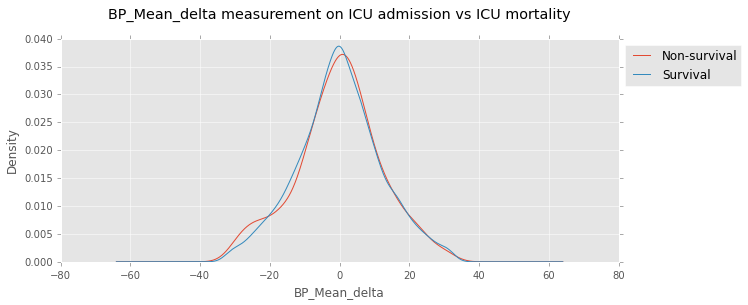

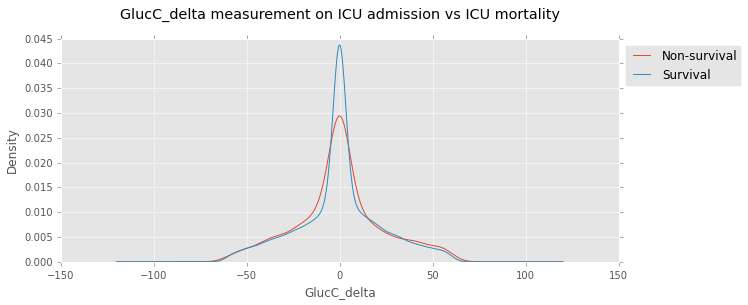

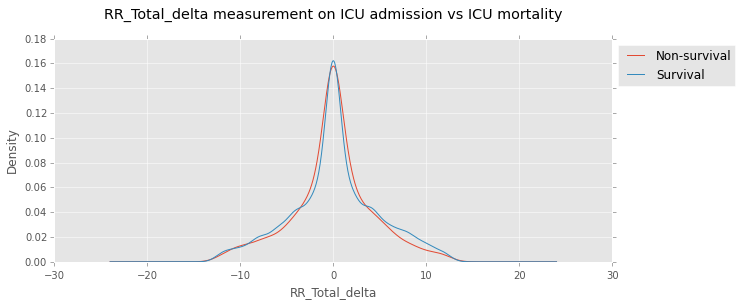

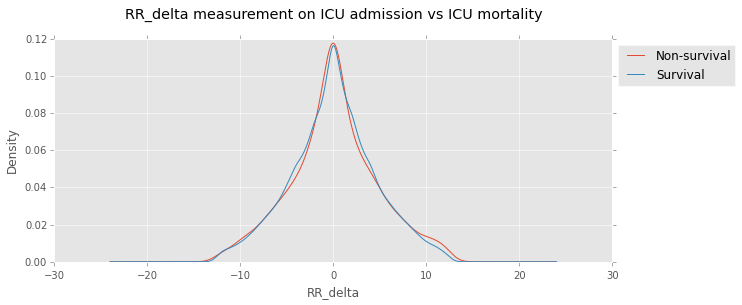

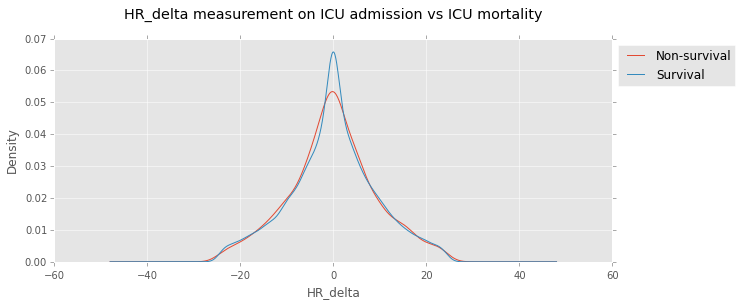

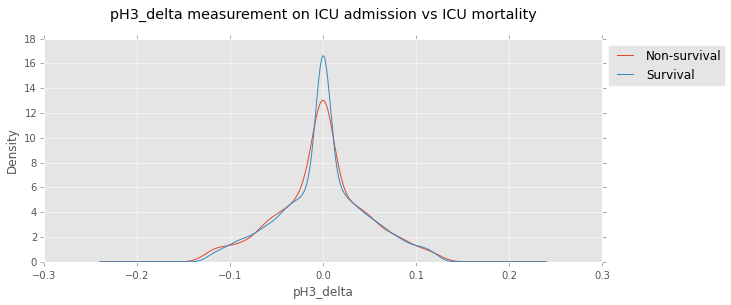

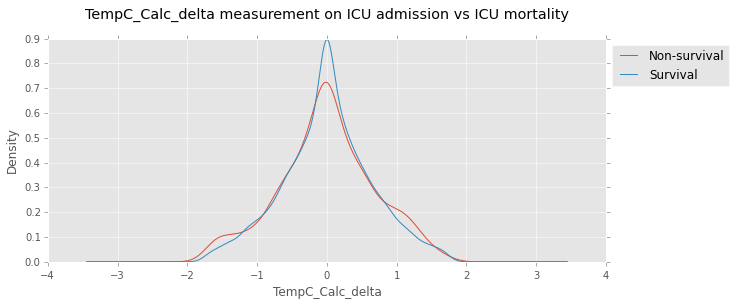

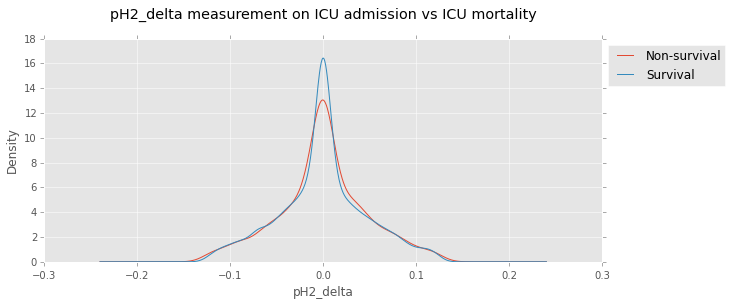

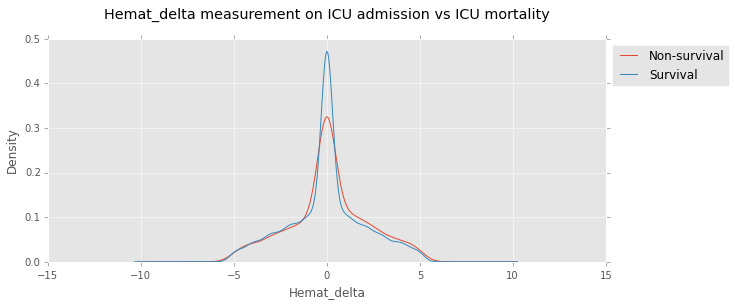

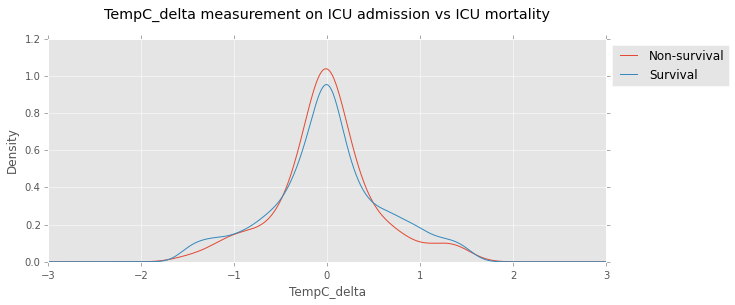

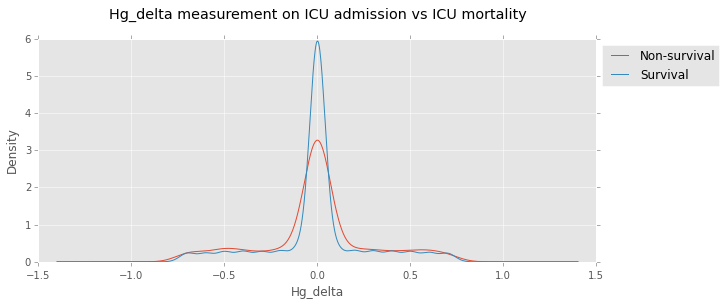

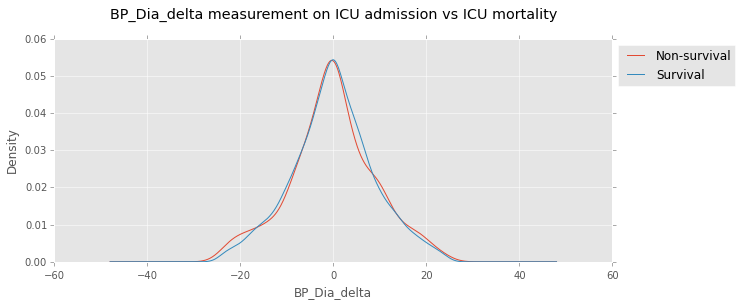

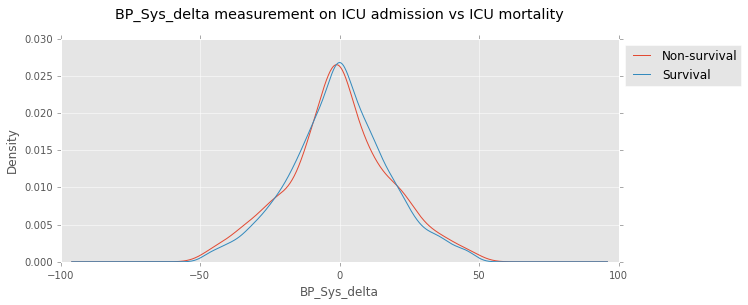

In [82]:
frame = delta_dict
for col in frame.keys():
    # plot
    # print col
    
  
    dummy = frame[col][frame[col].gender == 'M'] 
   

    col2 = dummy.columns[0]
       
    
    plt.subplots(figsize=(10,4))
    dummy[col2][dummy.hospital_expired_flag==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival')
    dummy[col2][dummy.hospital_expired_flag==0].dropna().plot.kde(
        alpha=1.0,label='Survival')

    # add title, labels etc.
    plt.title('{} measurement on ICU admission '.format(col) +
               'vs ICU mortality \n')
    plt.xlabel(col)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    
    
    #plt.xlim(dummy[col2].dropna().min(), dummy[col2].dropna().max())
    

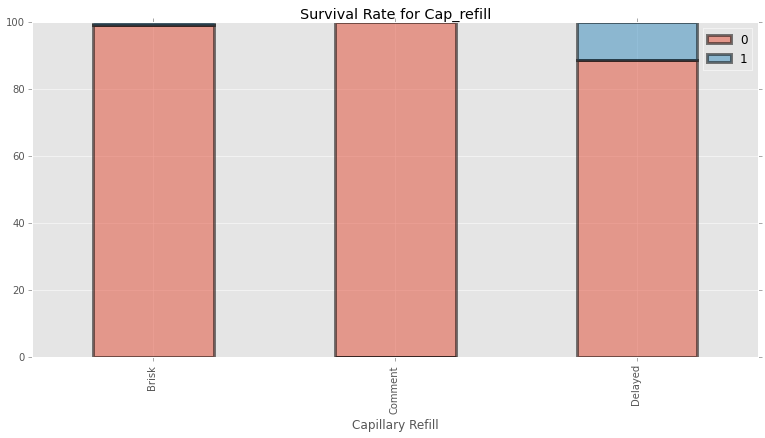

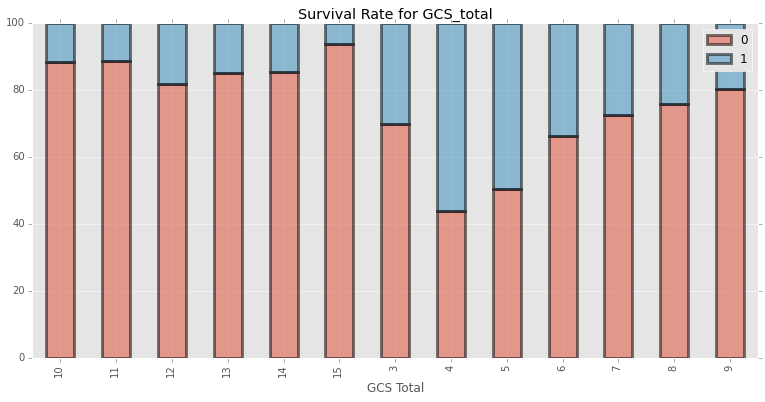

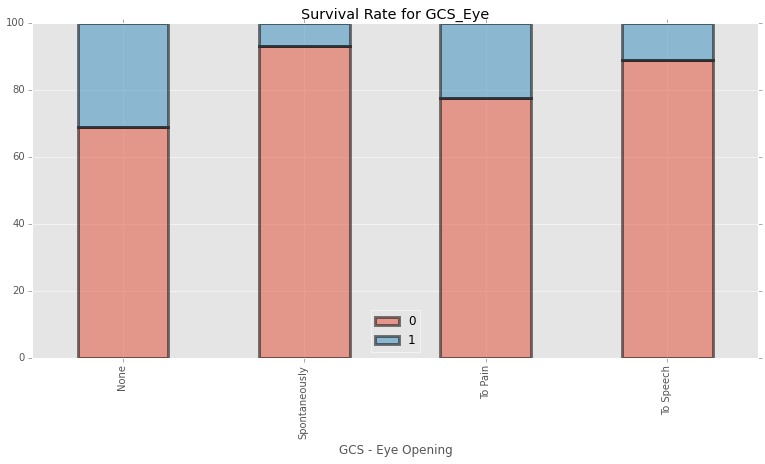

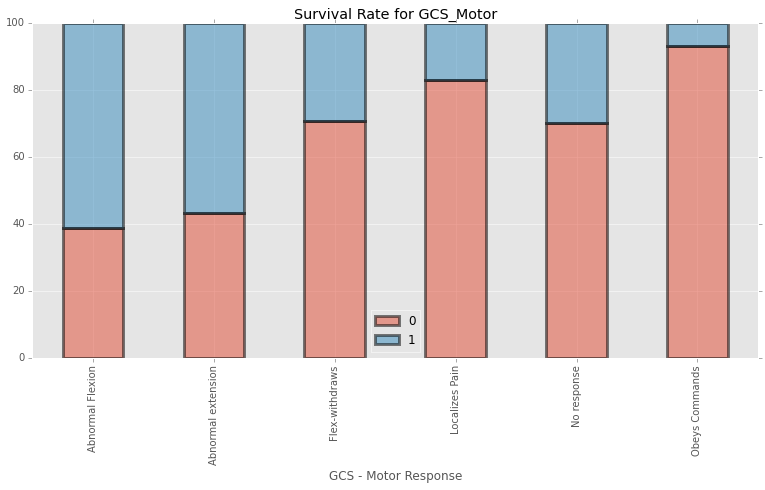

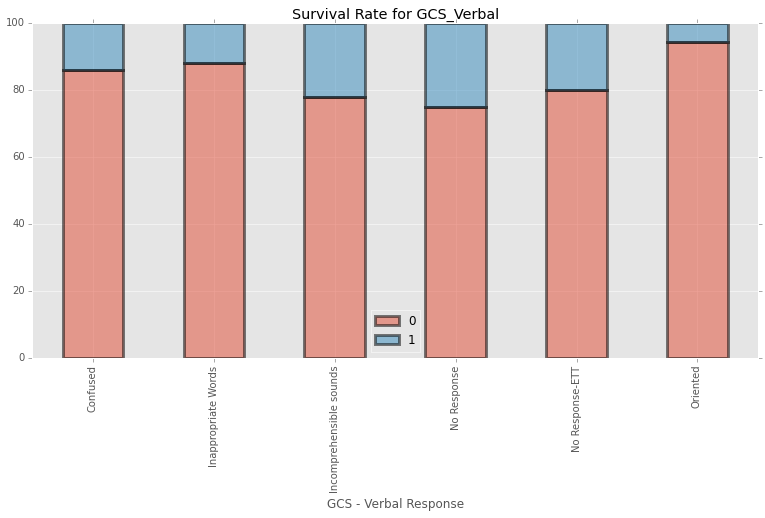

In [83]:
for col in cat_dict.keys():
    col2 = cat_dict_names[col]
    #print col
    #print col2
    vals = list(cat_dict[col][col2].unique())
    #display(vals)
    total = cat_dict[col].groupby(col2)[col2].count()
   
    dead = cat_dict[col][cat_dict[col].hospital_expired_flag == 1].groupby(col2)[col2].count()
    dead.name = 'Survivors'
    dead_percent = 100.00*(dead / total)
    live = cat_dict[col][cat_dict[col].hospital_expired_flag == 0].groupby(col2)[col2].count()
    live.name = 'Non_Survivors'
    live_percent = 100.00*(live / total)
    monkey = pd.concat([live_percent, dead_percent], axis = 1)

    #display(monkey)

    monkey.plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                alpha = 0.5, title = "Survival Rate for " + col)

In [84]:
const_dict.keys()

['Weight', 'Height']

In [85]:
gend = 'M'
col = const_dict.keys()[0]
col2 = const_dict_names[col]
print "{}   {}".format(col, col2)

dead = const_dict[col][(const_dict[col].hospital_expired_flag == 0)&
                          (const_dict[col].gender == gend)&
                          (const_dict[col][col2] >20)&
                          (const_dict[col][col2] < 700)]
display(dead[dead[col2] > 500])
display(dead.describe())

Weight   Admission Weight (Kg)


,Admission Weight (Kg),hospital_expired_flag,gender
icustay_id,,,


,Admission Weight (Kg),hospital_expired_flag
count,10046.000000,10046.0
mean,86.597742,0.0
std,22.190327,0.0
min,22.500000,0.0
25%,72.000000,0.0
50%,83.400000,0.0
75%,97.000000,0.0
max,310.000000,0.0


M
159.39    46.043
F
154.03    36.58
M
194.0    140.42
F
180.0    135.0


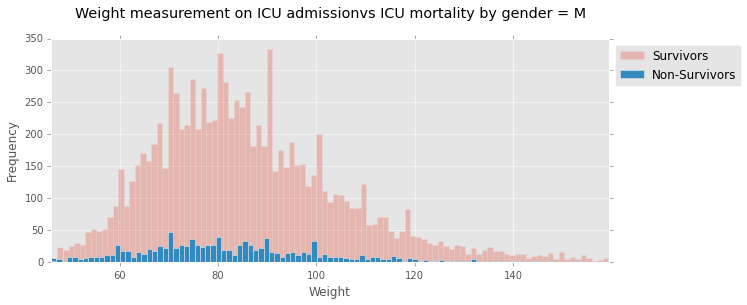

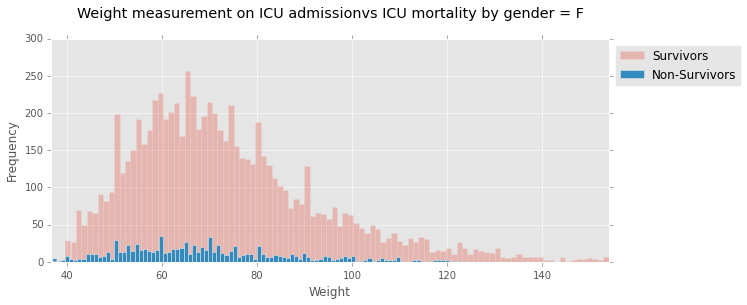

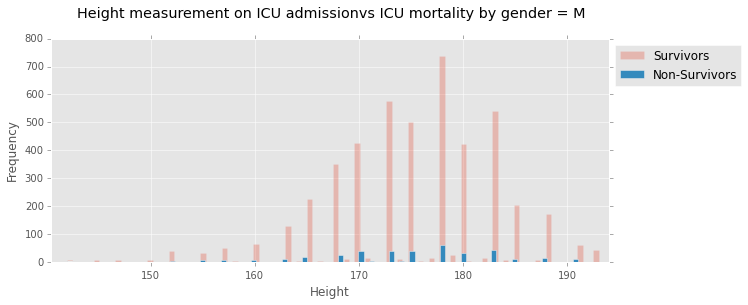

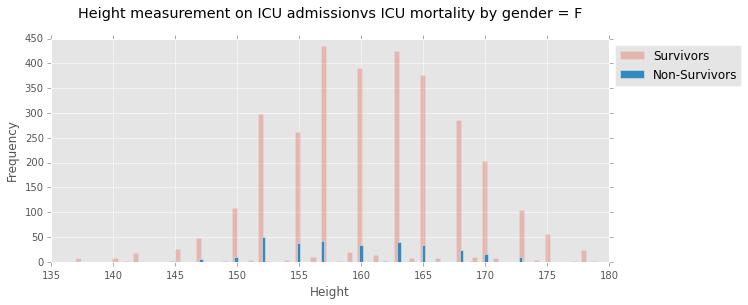

In [86]:
# PLOTTING CONSTANT VALUES LIKE HEIGHT AND WEIGHT

for col in const_dict.keys():
    
    col2 = const_dict_names[col]
    vals = list(const_dict[col][col2].unique())
    
    gender = ['M', 'F'] 
    
    for gend in gender:
        
        print gend
        dead = const_dict[col][(const_dict[col].hospital_expired_flag == 1)&
                              (const_dict[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        dead.name = 'Non_Survivors'
        live = const_dict[col][(const_dict[col].hospital_expired_flag == 0)&
                              (const_dict[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        live.name = 'Survivors'
    
    
        #display(dummy.head())
        # MAY WANT TO DO THIS WITH SURVIVOR AND NON-SURVIVOR GROUPS 
        '''
        all_outliers = []
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(dummy[dummy.columns[0]].dropna(), 25)
        #print Q1
        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(dummy[dummy.columns[0]].dropna(), 75)
        #print Q3
        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)
        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        # ~ == not
        all_outliers.extend(dummy[~((dummy[dummy.columns[0]] >= Q1 - step) & 
                                  (dummy[dummy.columns[0]] <= Q3 + step))].index)
        # OPTIONAL: Select the indices for data points you wish to remove
        print "the total outlier indices = {}".format(len(all_outliers))
    
        outliers  = all_outliers #list(outlier_df[outlier_df.counts 1>= 2].indices.values)
        #print "the following data points are outliers and will be removed: \n{}".format(outliers)
        # Remove the outliers, if any were specified
        #display(outliers[:5])
        #boxcox_data2 = boxcox_data.drop(boxcox_data.index[outliers]).reset_index(drop = True)
        dummy.drop(outliers, inplace = True)# .reset_index(drop = True)    
        '''   
        maxx = 0.99
        minn = 0.01
    
        live_max = live[col2].quantile(maxx)
        live_min = live[col2].quantile(minn)
        dead_max = dead[col2].quantile(maxx)
        dead_min = dead[col2].quantile(minn)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
   
    
    
        plt.subplots(figsize=(10,4))
        #live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.hist(bins = 100, alpha=0.3,label='Survivors')
        #live[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.hist(bins = 20, alpha=1.0,label='Non-Survivors')
    
        live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.hist(bins = 100, 
                                                                            alpha=0.3,label='Survivors')
    
        dead[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.hist(bins = 100, 
                                                                            alpha=1.0,label='Non-Survivors')
        # add title, labels etc.
        plt.title('{} measurement on ICU admission'.format(col) + 
                   'vs ICU mortality by gender = {}\n'.format(gend))
        plt.xlabel(col)
        plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   
    
        print "{}    {}".format(maxlim, minlim)
        plt.xlim(minlim, maxlim)
    

## MERGING CONTINUOUS DATA INCLUDING CONSTANTS (WEIGHT, HEIGHT ETC) INTO SINGLE DATAFRAME

In [87]:
# MERGE DATAFRAMES HERE 
# QUESTION UTILITY OF HAVING INDIVIDUAL FRAMES
# ** CAN BE CODED MORE EFFICIENTLY. SEE LABEVENTS_FIRST24.ipynb ** 
data2 = data.drop_duplicates('icustay_id', keep = 'first')
data3 = data2.drop(['label', 'value', 'valuenum'], axis = 1)
data3.set_index(['icustay_id'], inplace = True)


for col in mean_dict.keys():
    col2 = mean_dict_names[col]
    data3 = data3.merge(pd.DataFrame(mean_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols


for col in med_dict.keys():
    col2 = med_dict_names[col]
    data3 = data3.merge(pd.DataFrame(med_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols
    
for col in std_dict.keys():
    col2 = std_dict_names[col]
    data3 = data3.merge(pd.DataFrame(std_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols

for col in skew_dict.keys():
    col2 = skew_dict_names[col]
    data3 = data3.merge(pd.DataFrame(skew_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols
    
for col in min_dict.keys():
    col2 = min_dict_names[col]
    data3 = data3.merge(pd.DataFrame(min_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols
    
for col in max_dict.keys():
    col2 = max_dict_names[col]
    data3 = data3.merge(pd.DataFrame(max_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols
    
for col in first_dict.keys():
    col2 = first_dict_names[col]
    data3 = data3.merge(pd.DataFrame(first_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols

for col in delta_dict.keys():
    col2 = delta_dict_names[col]
    data3 = data3.merge(pd.DataFrame(delta_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols
    
for col in slope_dict.keys():
    col2 = slope_dict_names[col]
    data3 = data3.merge(pd.DataFrame(slope_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols
    
for col in const_dict.keys():
    col2 = const_dict_names[col]
    data3 = data3.merge(pd.DataFrame(const_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols


'''    
CREATING SEPARATE DATAFRAMES FOR CATEGORICAL DATA 

for col in cat_dict.keys():
    col2 = cat_dict_names[col]
    data3 = data3.merge(pd.get_dummies(cat_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols
'''

data3['icustay_id'] = data3.index
cols = list(data3.columns)
cols.sort()
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('subject_id')))
cols.insert(2, cols.pop(cols.index('hospital_expire_flag')))


data3 = data3[cols]
data3.set_index(np.arange(data3.shape[0]), inplace = True)
data3.head()

,icustay_id,subject_id,hospital_expire_flag,BP_Dia_delta,BP_Dia_first,BP_Dia_max,BP_Dia_mean,BP_Dia_med,BP_Dia_min,BP_Dia_skew,...,pH2_std,pH3_delta,pH3_first,pH3_max,pH3_mean,pH3_med,pH3_min,pH3_skew,pH3_slope,pH3_std
0,200001,55973,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200003,27513,0,7.0,58.0,81.0,42.708333,60.5,NaN,-0.623249,...,0.038987,-0.05,7.41,7.46,7.398,7.38,7.36,1.220037,0.002985,0.038987
2,200006,10950,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200007,20707,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200009,29904,0,-1.0,59.0,84.0,62.645161,57.0,49.0,0.868910,...,0.071063,-0.11,7.50,7.50,7.380,7.39,7.29,0.360059,-0.014505,0.071063


In [ ]:
data3['Weight'].mean()

## CONVERTING CATEGORICAL TO DUMMY DATA AND BREAKING UP INTO AFFINITY GROUPS. THREE RESULTING DATAFRAMES

In [88]:
dummies = data3[data3.columns[:3]]
dummies.set_index(['icustay_id'], inplace = True)
#display(monkey.head())
for col in cat_dict.keys():
    col2 = cat_dict_names[col]
    chimp = pd.get_dummies(cat_dict[col][col2], prefix = cat_dict[col][col2].name)
    dummies = dummies.merge(chimp, left_index = True, right_index = True, 
                       how = 'left', sort = True)
    
    '''
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols
    '''




#monkey = monkey.merge(chimp, left_index = True, right_index = True, 
#                       how = 'left', sort = True)

display(dummies.head())

# MEASURES HAVE LOW AFFINITY I.E. WHEN WE DROP NAN VALUES THERE ARE VERY FEW SAMPLES LEFT 
# SO BREAKING THESE UP INTO HIGH AFFINITY DATAFRAMES FOR PROCESSING. 
# ** MAY CONSIDER PROCESSING GCS_TOTAL AS A CONTINUOUS BUT, FOR NOW CREATING DUMMIES


# NUMBER OF NON NAN SAMPLES IN CAPILLARY REFILL
display(dummies[[x for x in dummies.columns if 'Capillary' in x]].dropna().shape)
# NUMBER OF NON NAN SAMPLES IN GCS_TOTAL ONLY
display(dummies[[x for x in dummies.columns if 'Total' in x]].dropna().shape)
# NUMBER OF NON NAN SAMPLES IN GCS MEASURES WITHOUT TOTAL 
display(dummies[[x for x in dummies.columns if (('GCS' in x) & ('Total' not in x))]].dropna().shape)
# NUMBER OF NON NAN SAMPLES IN GCS TOTAL AND MEASEURES
display(dummies[[x for x in dummies.columns if 'GCS' in x]].dropna().shape)
# NUMBER OF NON NAN SAMPLES IN GCS MEASURES AND CAP REFILL
display(dummies[[x for x in dummies.columns if 'Total' not in x]].dropna().shape)

dummies_Cap = dummies[[x for x in dummies.columns if 'Capillary' in x]].dropna()
dummies_GCS_Total = dummies[[x for x in dummies.columns if 'Total' in x]].dropna()
dummies_GCS = dummies[[x for x in dummies.columns if (('GCS' in x) & ('Total' not in x))]].dropna()

,subject_id,hospital_expire_flag,Capillary Refill_Brisk,Capillary Refill_Comment,Capillary Refill_Delayed,GCS Total_10,GCS Total_11,GCS Total_12,GCS Total_13,GCS Total_14,...,GCS - Motor Response_Flex-withdraws,GCS - Motor Response_Localizes Pain,GCS - Motor Response_No response,GCS - Motor Response_Obeys Commands,GCS - Verbal Response_Confused,GCS - Verbal Response_Inappropriate Words,GCS - Verbal Response_Incomprehensible sounds,GCS - Verbal Response_No Response,GCS - Verbal Response_No Response-ETT,GCS - Verbal Response_Oriented
icustay_id,,,,,,,,,,,,,,,,,,,,,
200001,55973,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
200003,27513,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200006,10950,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200007,20707,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200009,29904,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(5927, 3)

(28907, 13)

(23280, 16)

(19, 29)

(0, 21)

In [89]:
[x for x in data3.columns if 'skew' in x]

['BP_Dia_skew',
 'BP_Mean_skew',
 'BP_Sys_skew',
 'Creat2_skew',
 'GlucC_skew',
 'HR_skew',
 'Hemat_skew',
 'Hg_skew',
 'O2_Fraction_skew',
 'RR_Spont_skew',
 'RR_Total_skew',
 'RR_skew',
 'TempC_Calc_skew',
 'TempC_skew',
 'pH2_skew',
 'pH3_skew']

In [90]:
# THE FOLLOWING BLOCK OF CODE PLOTS COLORMAPS OF MISSING DATA POINTS. AFTER HAVING GONE THROUGH THAT PROCESS
# I'VE STEPPED BACK UP TO THIS POINT TO DROP COLUMNS THAT WERE SHOWN TO BE VERY SPARSE. THEN I'M PLOTTING THE 
# HEATMAPS AND CORRELATION MATRICES AGAIN TO SEE HOW MUCH DATA WE'RE LEFT WITH WHEN NAN'S ARE DROPPED. THIS IS AN 
# ITERATIVE PROCESS. 
# THE COLUMNS BEING DROPPED WERE IDENTIFIED AS SPARSE IN HEATMAPS BELOW
drop_cols = [x for x in data3.columns if (('O2_Fraction' in x) | (('TempC' in x) & ('TempC_Calc' not in x))) ]
more_cols = ['Creat2_skew', 'Hg_skew', 'RR_Spont_skew', 'RR_Total_skew']
for col in more_cols:
    drop_cols.append(col)
data3.drop(drop_cols, inplace = True, axis = 1)
data3.set_index(np.arange(data3.shape[0]), inplace = True)

/Users/robertbeetel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


5206

,BP_Dia_mean,BP_Mean_mean,BP_Sys_mean,Creat2_mean,GlucC_mean,HR_mean,Hemat_mean,Hg_mean,RR_Spont_mean,RR_Total_mean,RR_mean,TempC_Calc_mean,pH2_mean,pH3_mean
BP_Dia_mean,1.000000,0.984094,0.976311,0.556005,0.570494,NaN,0.590374,0.579163,0.681965,0.690378,NaN,0.412306,0.714929,0.751000
BP_Mean_mean,0.984094,1.000000,0.977388,0.555818,0.570405,NaN,0.589331,0.578214,0.683976,0.692028,NaN,0.410342,0.715888,0.752097
BP_Sys_mean,0.976311,0.977388,1.000000,0.557435,0.571054,NaN,0.589288,0.578515,0.683044,0.690657,NaN,0.412956,0.717827,0.753900
Creat2_mean,0.556005,0.555818,0.557435,1.000000,0.847938,NaN,0.871918,0.860755,0.482198,0.510916,NaN,0.744275,0.555615,0.580223
GlucC_mean,0.570494,0.570405,0.571054,0.847938,1.000000,NaN,0.928575,0.918308,0.492685,0.526109,NaN,0.797038,0.588369,0.612488
HR_mean,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.565805,NaN,NaN,NaN
Hemat_mean,0.590374,0.589331,0.589288,0.871918,0.928575,NaN,1.000000,0.975351,0.507019,0.542188,NaN,0.832548,0.603730,0.629876
Hg_mean,0.579163,0.578214,0.578515,0.860755,0.918308,NaN,0.975351,1.000000,0.498237,0.533275,NaN,0.820119,0.602822,0.620712
RR_Spont_mean,0.681965,0.683976,0.683044,0.482198,0.492685,NaN,0.507019,0.498237,1.000000,0.920590,NaN,NaN,0.686355,0.720218
RR_Total_mean,0.690378,0.692028,0.690657,0.510916,0.526109,NaN,0.542188,0.533275,0.920590,1.000000,NaN,NaN,0.721010,0.756164


/Users/robertbeetel/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


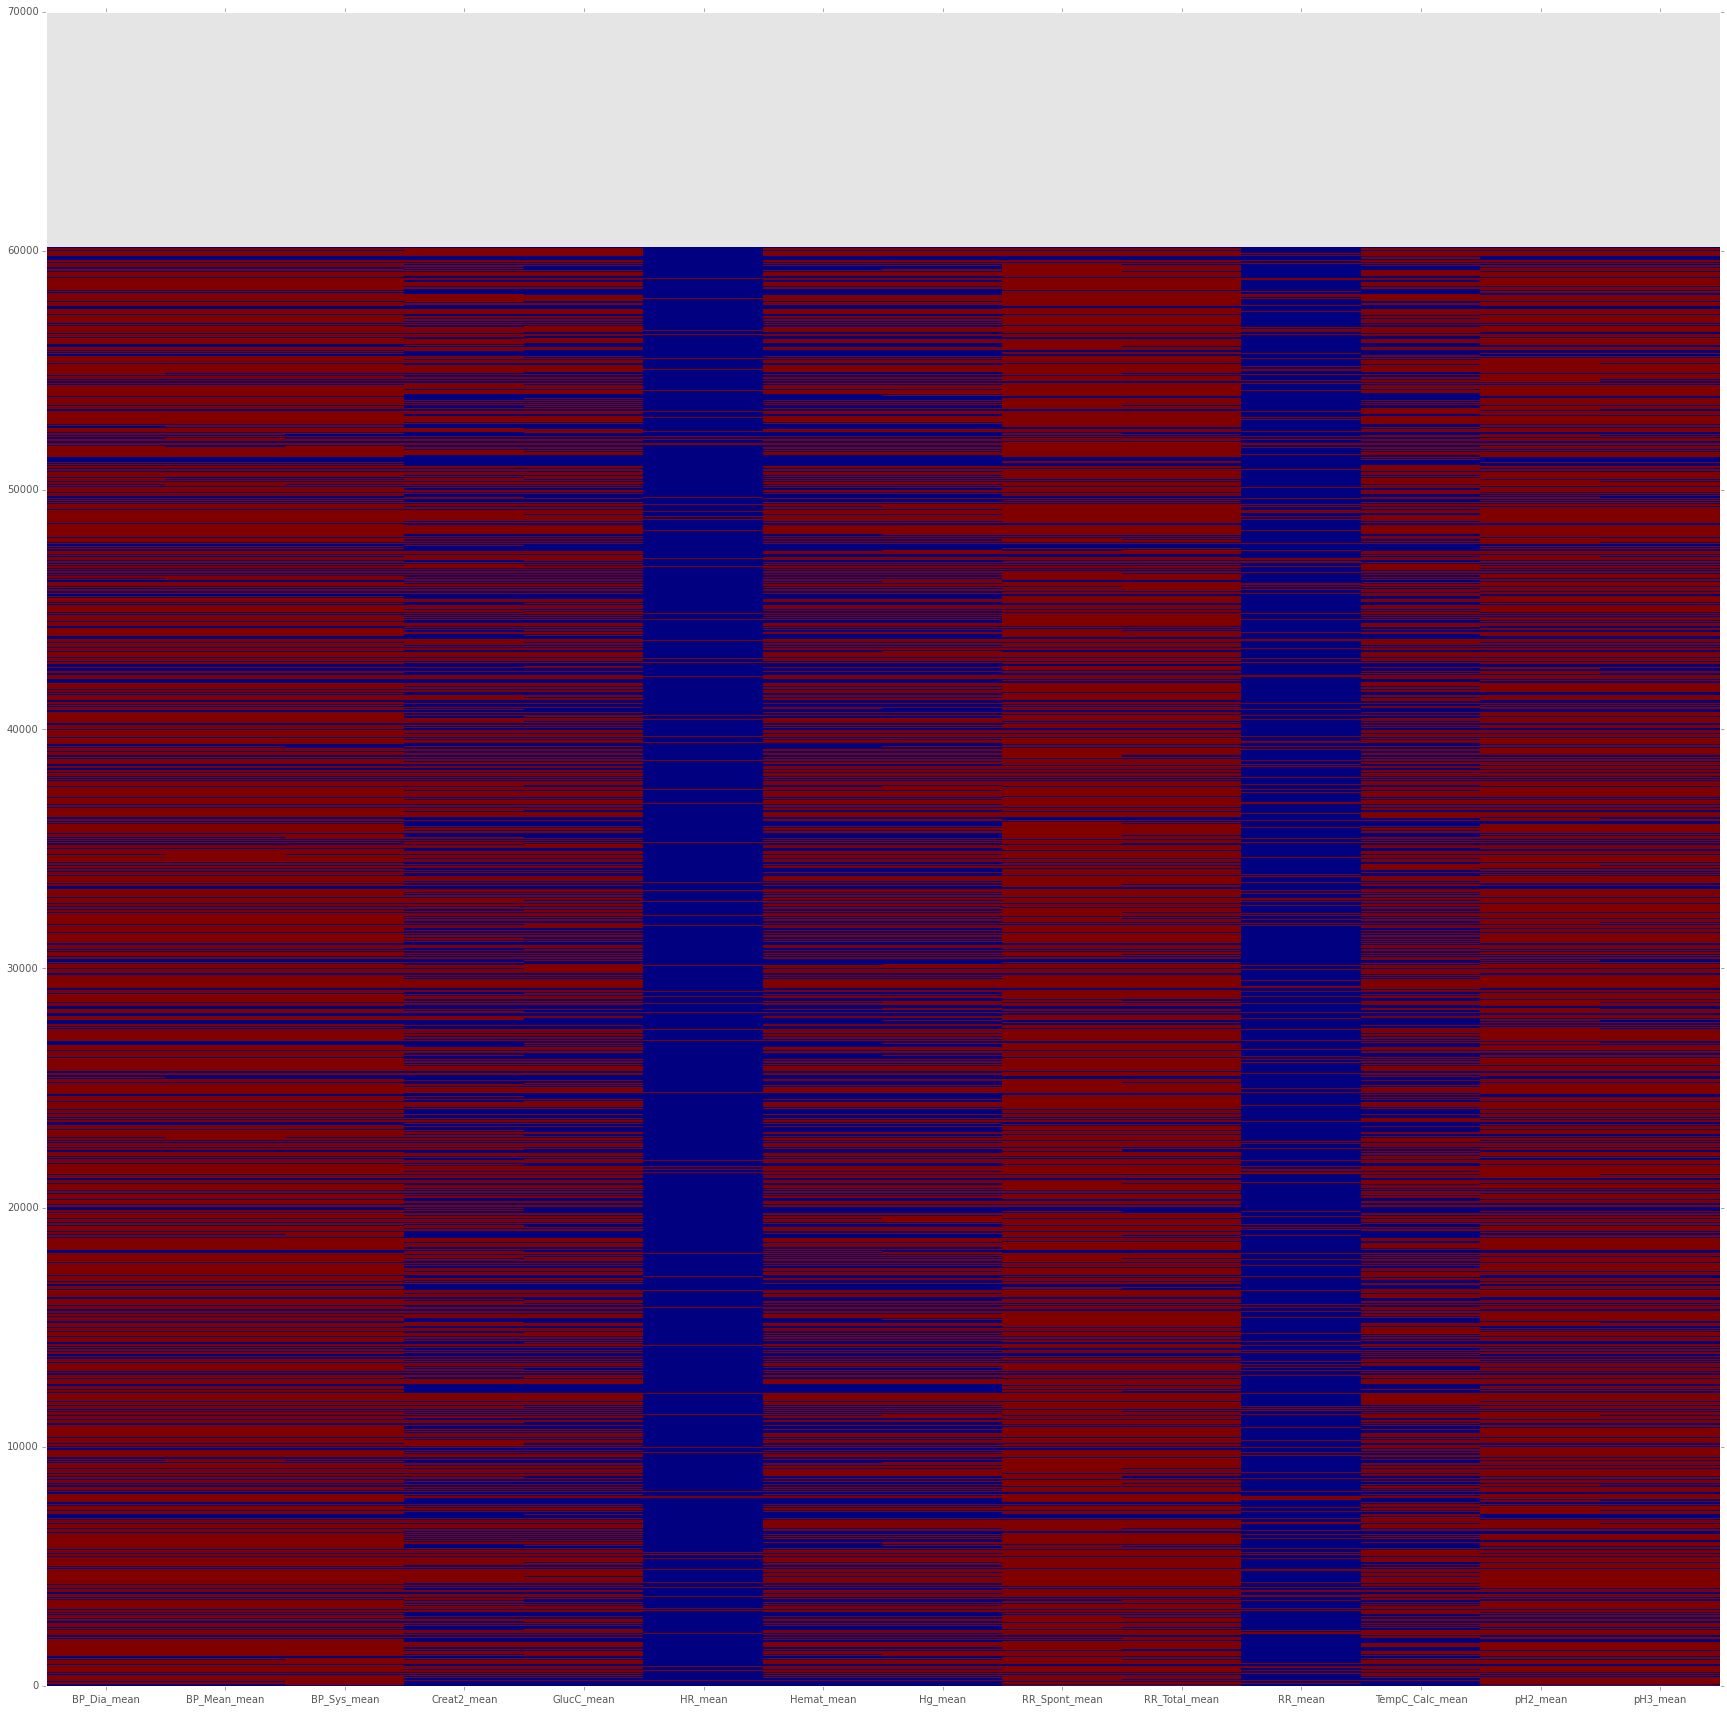

5077

,BP_Dia_med,BP_Mean_med,BP_Sys_med,Creat2_med,GlucC_med,HR_med,Hemat_med,Hg_med,RR_Spont_med,RR_Total_med,RR_med,TempC_Calc_med,pH2_med,pH3_med
BP_Dia_med,1.000000,0.985235,0.979915,0.556939,0.569638,NaN,0.591584,0.580026,0.672865,0.690329,NaN,0.413346,0.717043,0.753966
BP_Mean_med,0.985235,1.000000,0.981036,0.556693,0.568543,NaN,0.589740,0.578253,0.673616,0.690889,NaN,0.409847,0.716725,0.753612
BP_Sys_med,0.979915,0.981036,1.000000,0.559050,0.570341,NaN,0.591282,0.579957,0.674015,0.690405,NaN,0.413687,0.718756,0.755381
Creat2_med,0.556939,0.556693,0.559050,1.000000,0.848676,NaN,0.872872,0.861048,0.473435,0.510952,NaN,0.744767,0.556624,0.581298
GlucC_med,0.569638,0.568543,0.570341,0.848676,1.000000,NaN,0.928703,0.918274,0.481413,0.522863,NaN,0.797395,0.588068,0.612855
HR_med,NaN,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,0.53335,NaN,NaN,NaN
Hemat_med,0.591584,0.589740,0.591282,0.872872,0.928703,NaN,1.000000,0.975229,0.497712,0.541025,NaN,0.832622,0.605563,0.632122
Hg_med,0.580026,0.578253,0.579957,0.861048,0.918274,NaN,0.975229,1.000000,0.488846,0.531853,NaN,0.819644,0.603955,0.622324
RR_Spont_med,0.672865,0.673616,0.674015,0.473435,0.481413,NaN,0.497712,0.488846,1.000000,0.900783,NaN,NaN,0.675183,0.708301
RR_Total_med,0.690329,0.690889,0.690405,0.510952,0.522863,NaN,0.541025,0.531853,0.900783,1.000000,NaN,NaN,0.722234,0.757901


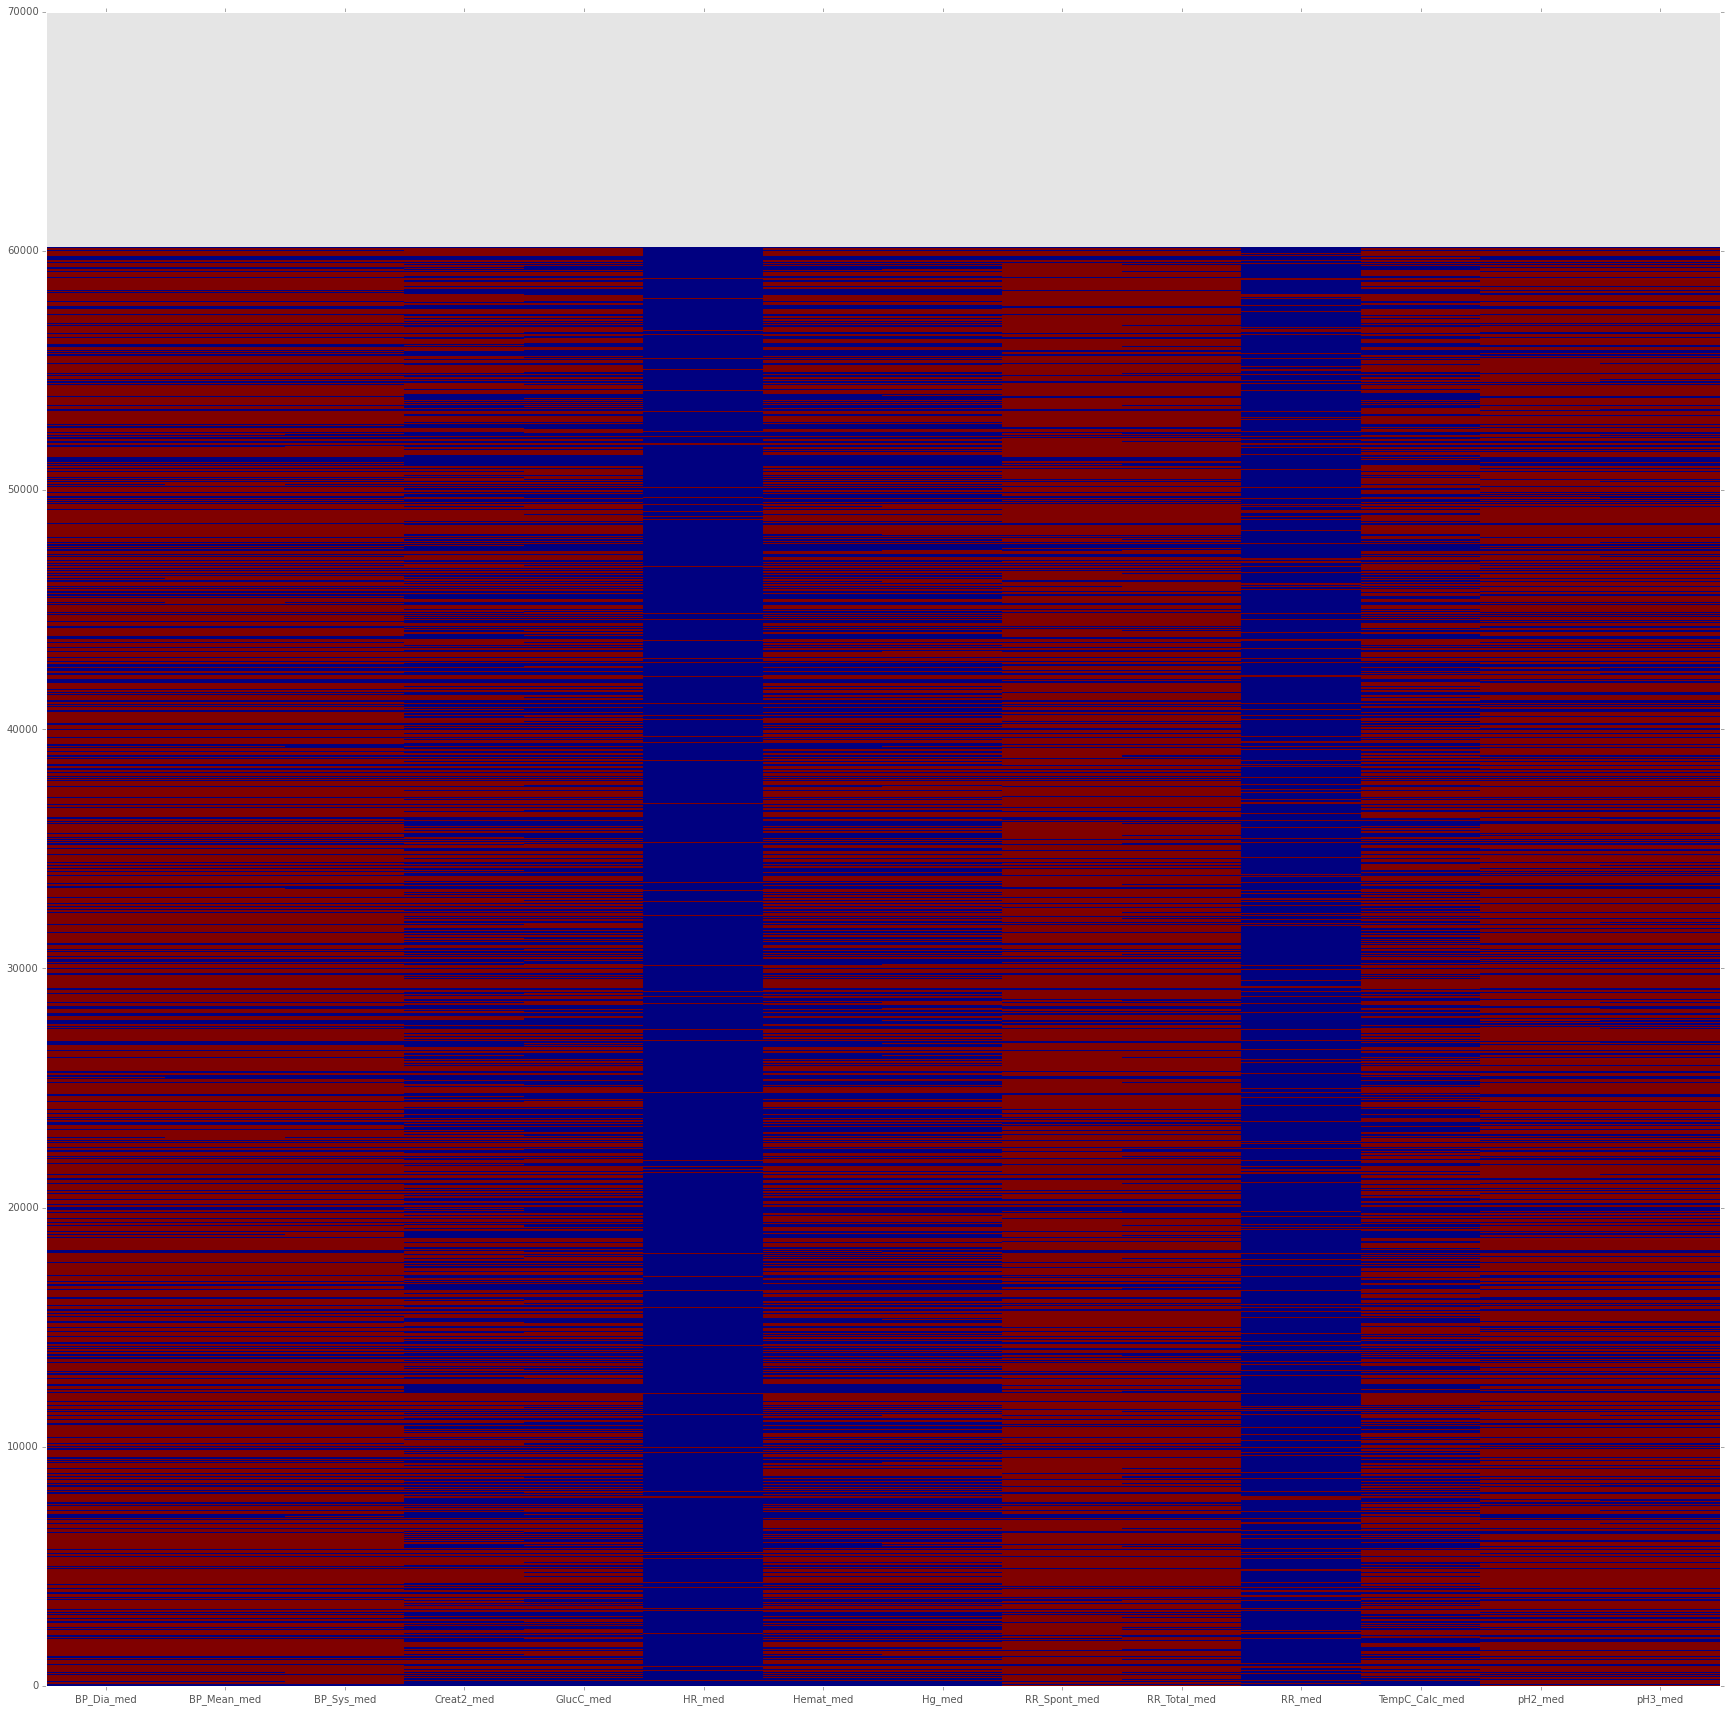

2061

,BP_Dia_std,BP_Mean_std,BP_Sys_std,Creat2_std,GlucC_std,HR_std,Hemat_std,Hg_std,RR_Spont_std,RR_Total_std,RR_std,TempC_Calc_std,pH2_std,pH3_std
BP_Dia_std,1.000000,0.949897,0.972705,0.488970,0.604761,NaN,0.593756,0.506976,0.588217,0.648302,NaN,NaN,0.725440,0.759245
BP_Mean_std,0.949897,1.000000,0.952364,0.487813,0.603214,NaN,0.591994,0.505269,0.589177,0.648034,NaN,NaN,0.726247,0.759881
BP_Sys_std,0.972705,0.952364,1.000000,0.491620,0.608553,NaN,0.597521,0.510085,0.590453,0.650680,NaN,NaN,0.728563,0.763055
Creat2_std,0.488970,0.487813,0.491620,1.000000,0.745747,NaN,0.691690,0.713461,NaN,0.440840,NaN,0.481189,0.487362,0.486012
GlucC_std,0.604761,0.603214,0.608553,0.745747,1.000000,NaN,0.753622,0.686254,0.473088,0.537764,NaN,0.534061,0.580820,0.604094
HR_std,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hemat_std,0.593756,0.591994,0.597521,0.691690,0.753622,NaN,1.000000,0.799863,0.454089,0.509479,NaN,0.564433,0.552969,0.575701
Hg_std,0.506976,0.505269,0.510085,0.713461,0.686254,NaN,0.799863,1.000000,0.415018,0.448840,NaN,0.460696,0.495951,0.495681
RR_Spont_std,0.588217,0.589177,0.590453,NaN,0.473088,NaN,0.454089,0.415018,1.000000,0.867340,NaN,NaN,0.647087,0.675051
RR_Total_std,0.648302,0.648034,0.650680,0.440840,0.537764,NaN,0.509479,0.448840,0.867340,1.000000,NaN,NaN,0.724374,0.756312


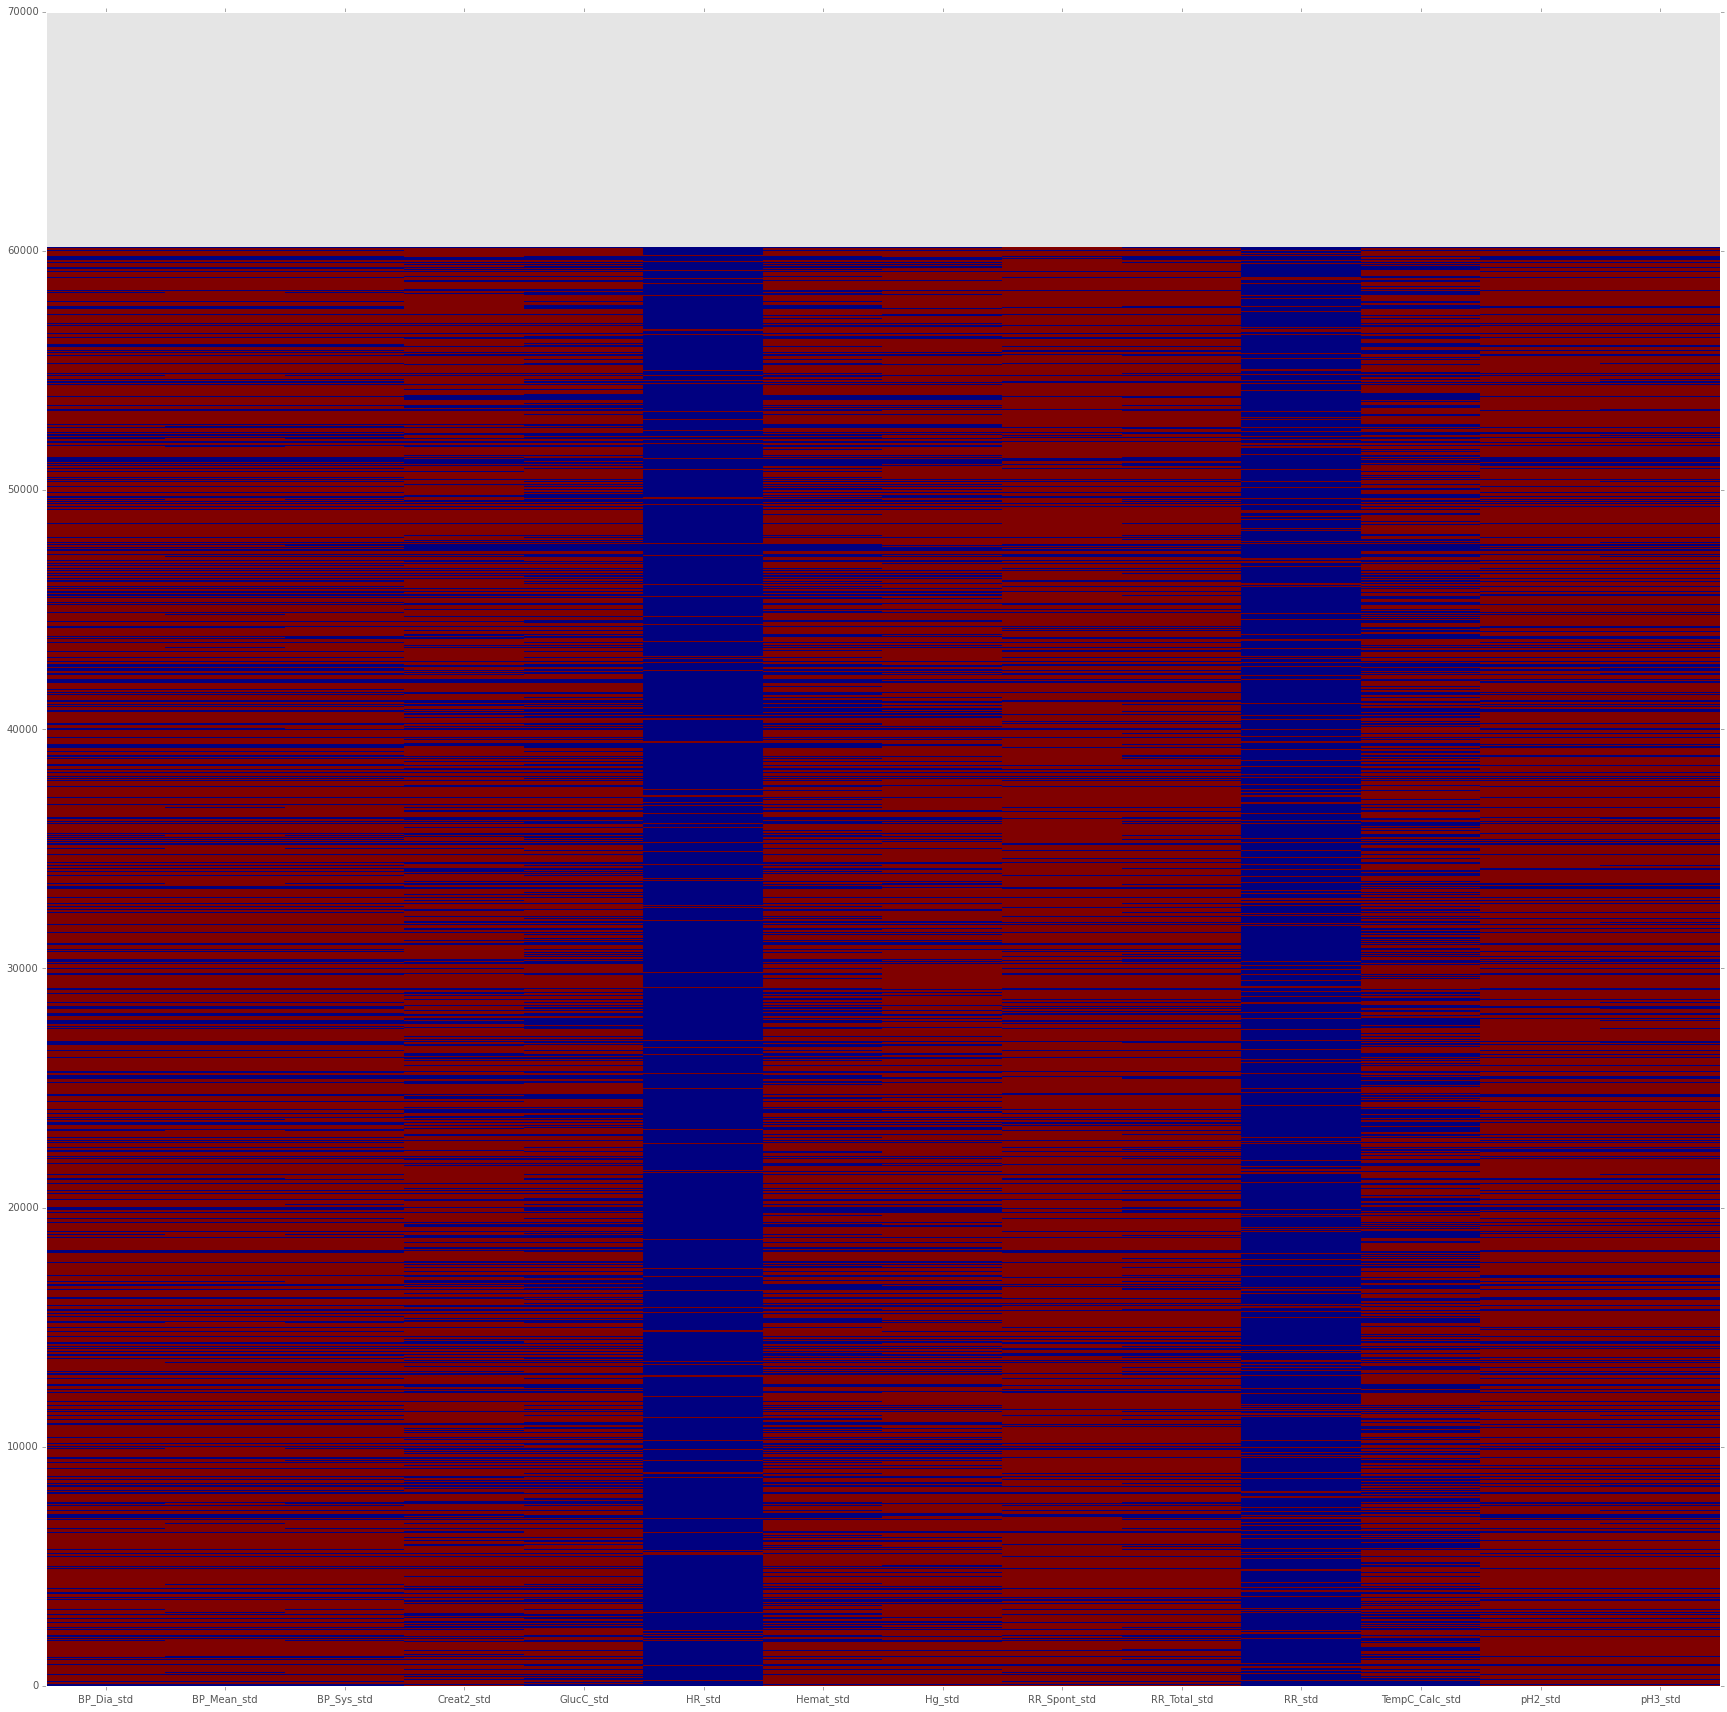

2905

,BP_Dia_skew,BP_Mean_skew,BP_Sys_skew,GlucC_skew,HR_skew,Hemat_skew,RR_skew,TempC_Calc_skew,pH2_skew,pH3_skew
BP_Dia_skew,1.000000,0.922516,0.961844,0.623153,NaN,0.570946,NaN,NaN,0.718697,0.751098
BP_Mean_skew,0.922516,1.000000,0.925164,0.610365,NaN,0.558706,NaN,NaN,0.709361,0.741194
BP_Sys_skew,0.961844,0.925164,1.000000,0.626234,NaN,0.573852,NaN,NaN,0.721892,0.754518
GlucC_skew,0.623153,0.610365,0.626234,1.000000,NaN,0.649830,NaN,NaN,0.650387,0.677046
HR_skew,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Hemat_skew,0.570946,0.558706,0.573852,0.649830,NaN,1.000000,NaN,NaN,0.581905,0.605748
RR_skew,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
TempC_Calc_skew,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
pH2_skew,0.718697,0.709361,0.721892,0.650387,NaN,0.581905,NaN,NaN,1.000000,0.959677
pH3_skew,0.751098,0.741194,0.754518,0.677046,NaN,0.605748,NaN,NaN,0.959677,1.000000


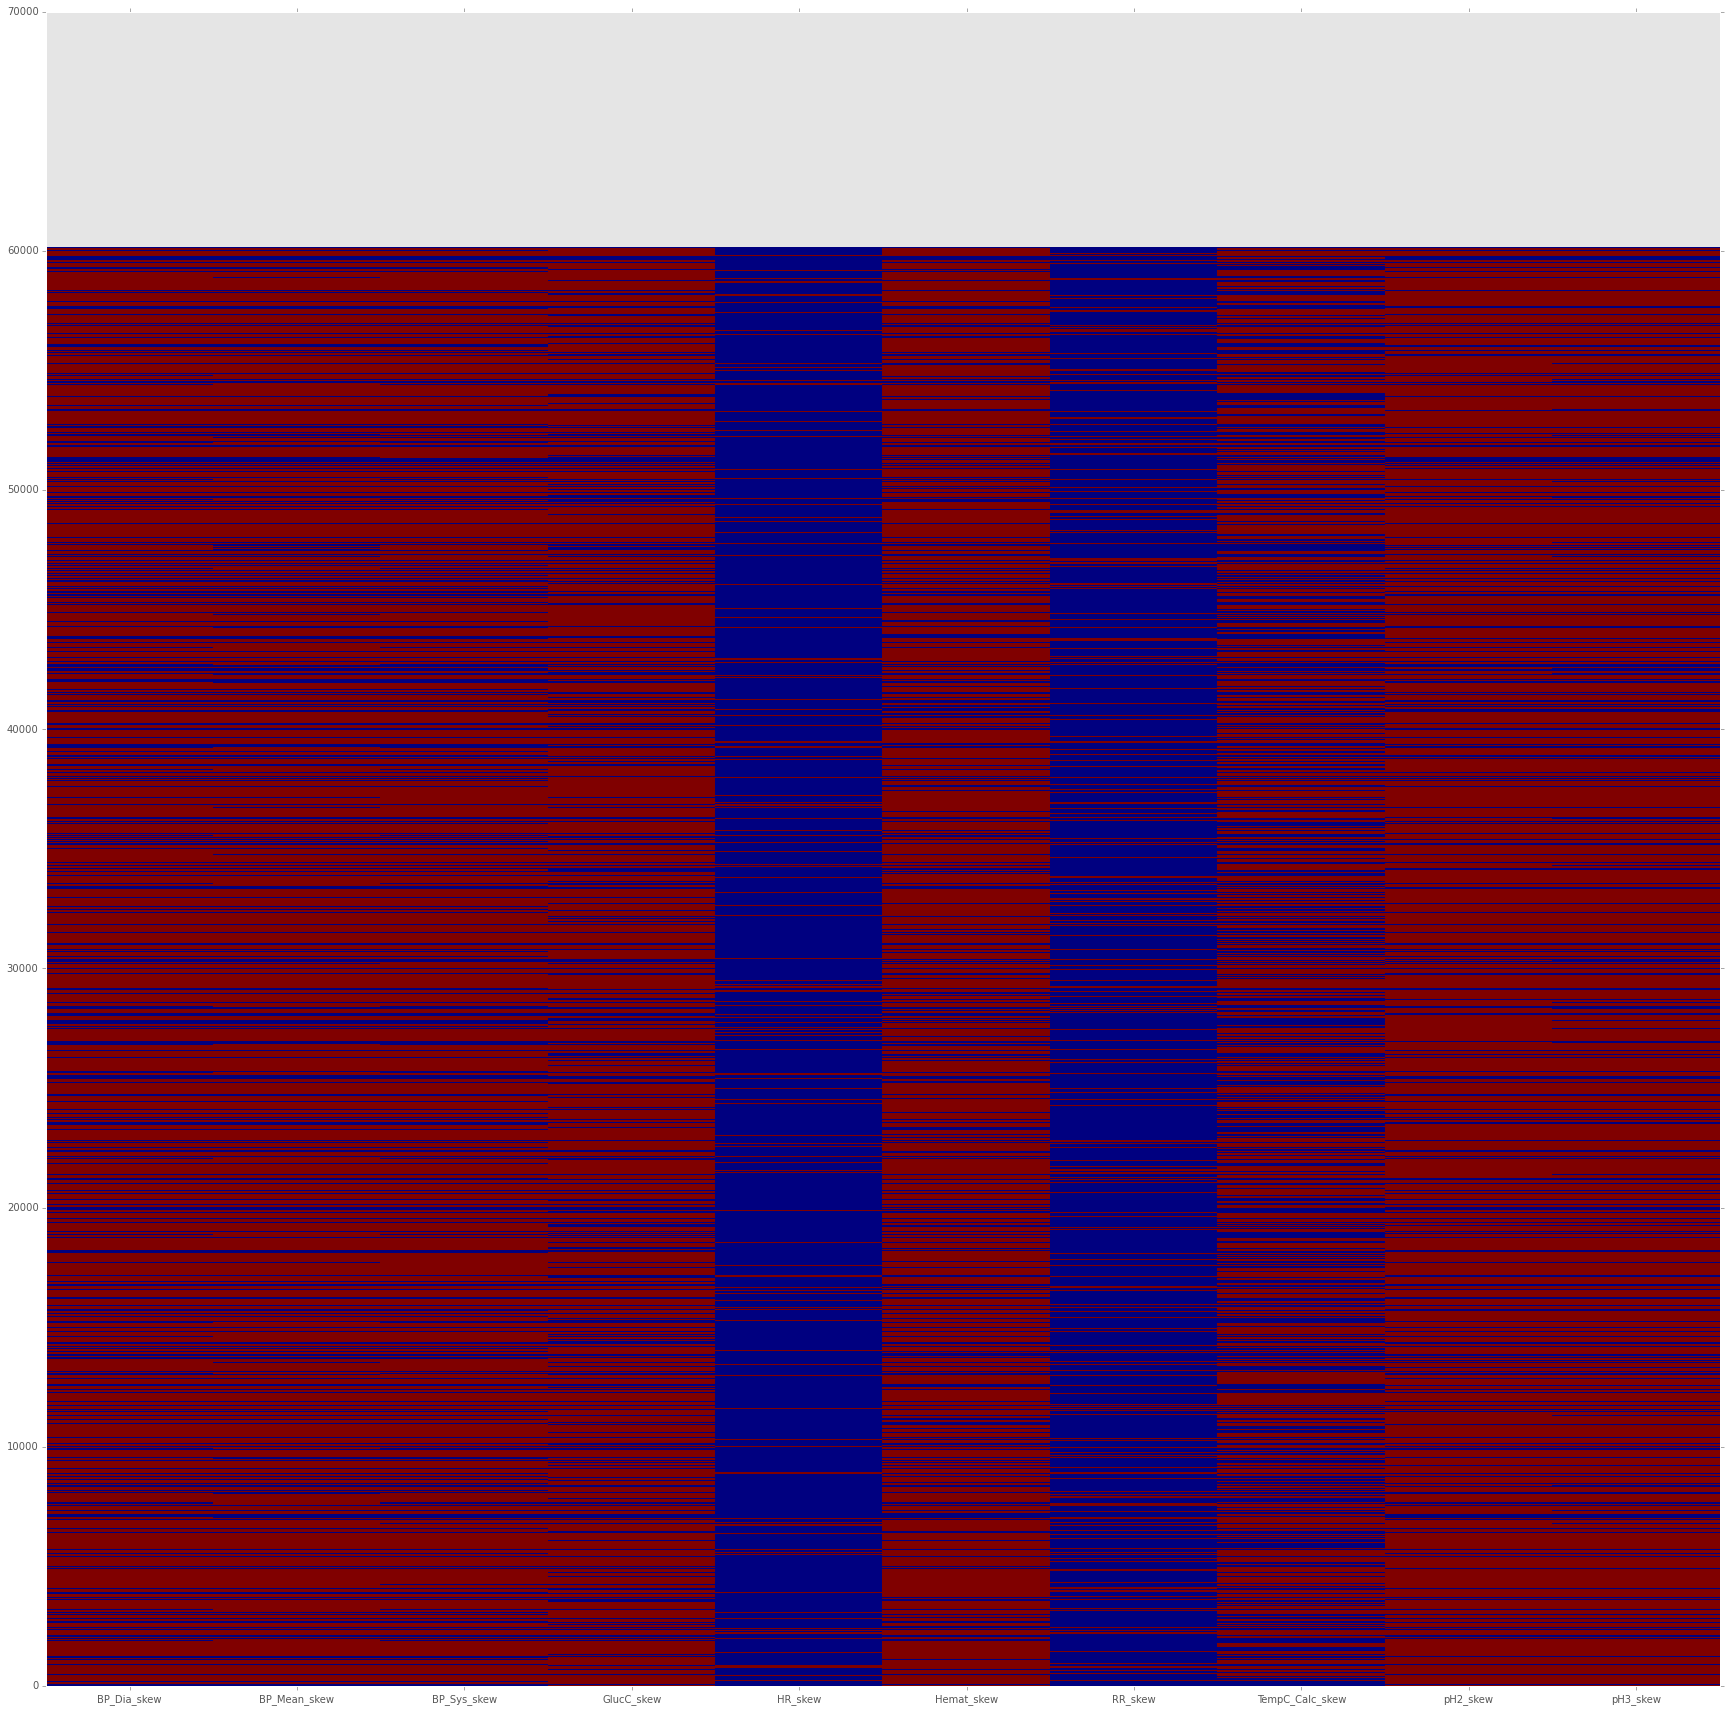

4563

,BP_Dia_min,BP_Mean_min,BP_Sys_min,Creat2_min,GlucC_min,HR_min,Hemat_min,Hg_min,RR_Total_min,RR_min,TempC_Calc_min,pH2_min,pH3_min
BP_Dia_min,1.000000,0.941816,0.975024,0.533109,0.551530,NaN,0.560139,0.550438,0.663332,NaN,NaN,0.679865,0.714889
BP_Mean_min,0.941816,1.000000,0.938617,0.540624,0.562086,NaN,0.571660,0.561809,0.681303,NaN,NaN,0.696961,0.732667
BP_Sys_min,0.975024,0.938617,1.000000,0.534224,0.552019,NaN,0.560004,0.550060,0.665137,NaN,NaN,0.682494,0.717039
Creat2_min,0.533109,0.540624,0.534224,1.000000,0.850104,NaN,0.873662,0.861535,0.507765,NaN,0.735767,0.552410,0.576286
GlucC_min,0.551530,0.562086,0.552019,0.850104,1.000000,NaN,0.935633,0.924883,0.527056,NaN,0.792811,0.591857,0.617803
HR_min,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.558851,NaN,NaN,NaN
Hemat_min,0.560139,0.571660,0.560004,0.873662,0.935633,NaN,1.000000,0.975812,0.534992,NaN,0.829740,0.603957,0.629957
Hg_min,0.550438,0.561809,0.550060,0.861535,0.924883,NaN,0.975812,1.000000,0.527042,NaN,0.816283,0.602354,0.620538
RR_Total_min,0.663332,0.681303,0.665137,0.507765,0.527056,NaN,0.534992,0.527042,1.000000,NaN,NaN,0.709023,0.744233
RR_min,NaN,NaN,NaN,NaN,NaN,0.558851,NaN,NaN,NaN,1.000000,NaN,NaN,NaN


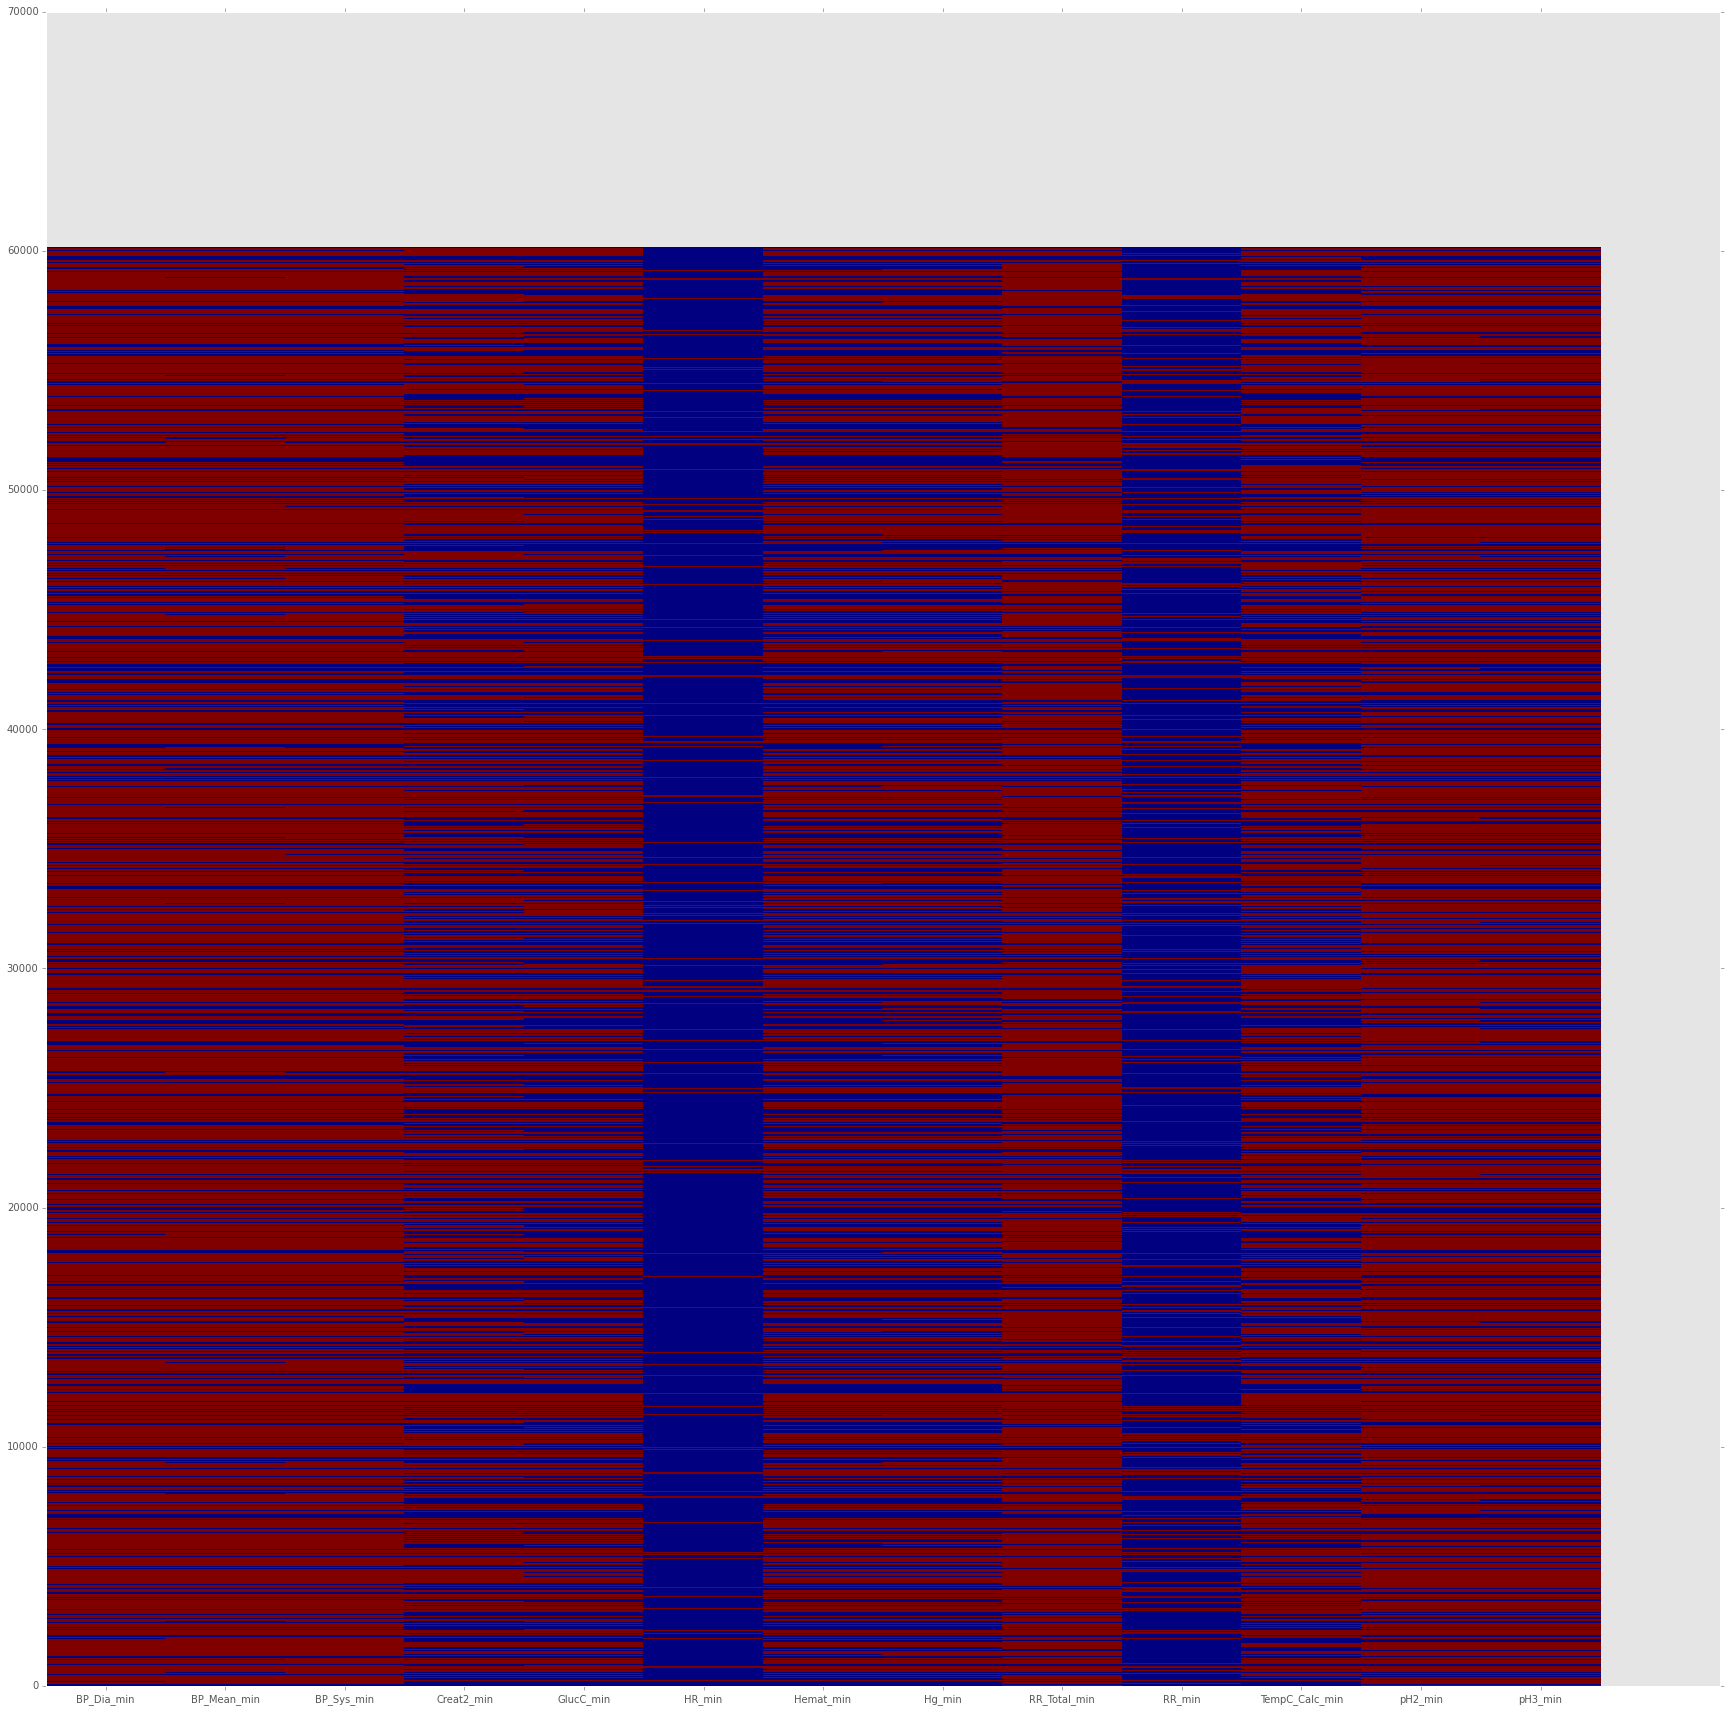

4745

,BP_Dia_max,BP_Mean_max,BP_Sys_max,Creat2_max,GlucC_max,HR_max,Hemat_max,Hg_max,RR_Spont_max,RR_Total_max,RR_max,TempC_Calc_max,pH2_max,pH3_max
BP_Dia_max,1.000000,0.952279,0.974634,0.553542,0.558905,NaN,0.583518,0.573133,0.677689,0.683750,NaN,0.414565,0.711454,0.747268
BP_Mean_max,0.952279,1.000000,0.952445,0.541013,0.546184,NaN,0.569185,0.558746,0.660194,0.665146,NaN,0.402524,0.693705,0.728411
BP_Sys_max,0.974634,0.952445,1.000000,0.558309,0.563461,NaN,0.587106,0.576809,0.681860,0.687781,NaN,0.419292,0.717615,0.753890
Creat2_max,0.553542,0.541013,0.558309,1.000000,0.858173,NaN,0.879685,0.868665,0.487106,0.514069,NaN,0.752016,0.559398,0.584278
GlucC_max,0.558905,0.546184,0.563461,0.858173,1.000000,NaN,0.930360,0.919375,0.489403,0.522318,NaN,0.802646,0.582746,0.607099
HR_max,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hemat_max,0.583518,0.569185,0.587106,0.879685,0.930360,NaN,1.000000,0.973784,0.509480,0.542021,NaN,0.834857,0.604657,0.630980
Hg_max,0.573133,0.558746,0.576809,0.868665,0.919375,NaN,0.973784,1.000000,0.502990,0.535717,NaN,0.821483,0.605346,0.623725
RR_Spont_max,0.677689,0.660194,0.681860,0.487106,0.489403,NaN,0.509480,0.502990,1.000000,0.931687,NaN,NaN,0.701564,0.734947
RR_Total_max,0.683750,0.665146,0.687781,0.514069,0.522318,NaN,0.542021,0.535717,0.931687,1.000000,NaN,NaN,0.732003,0.766603


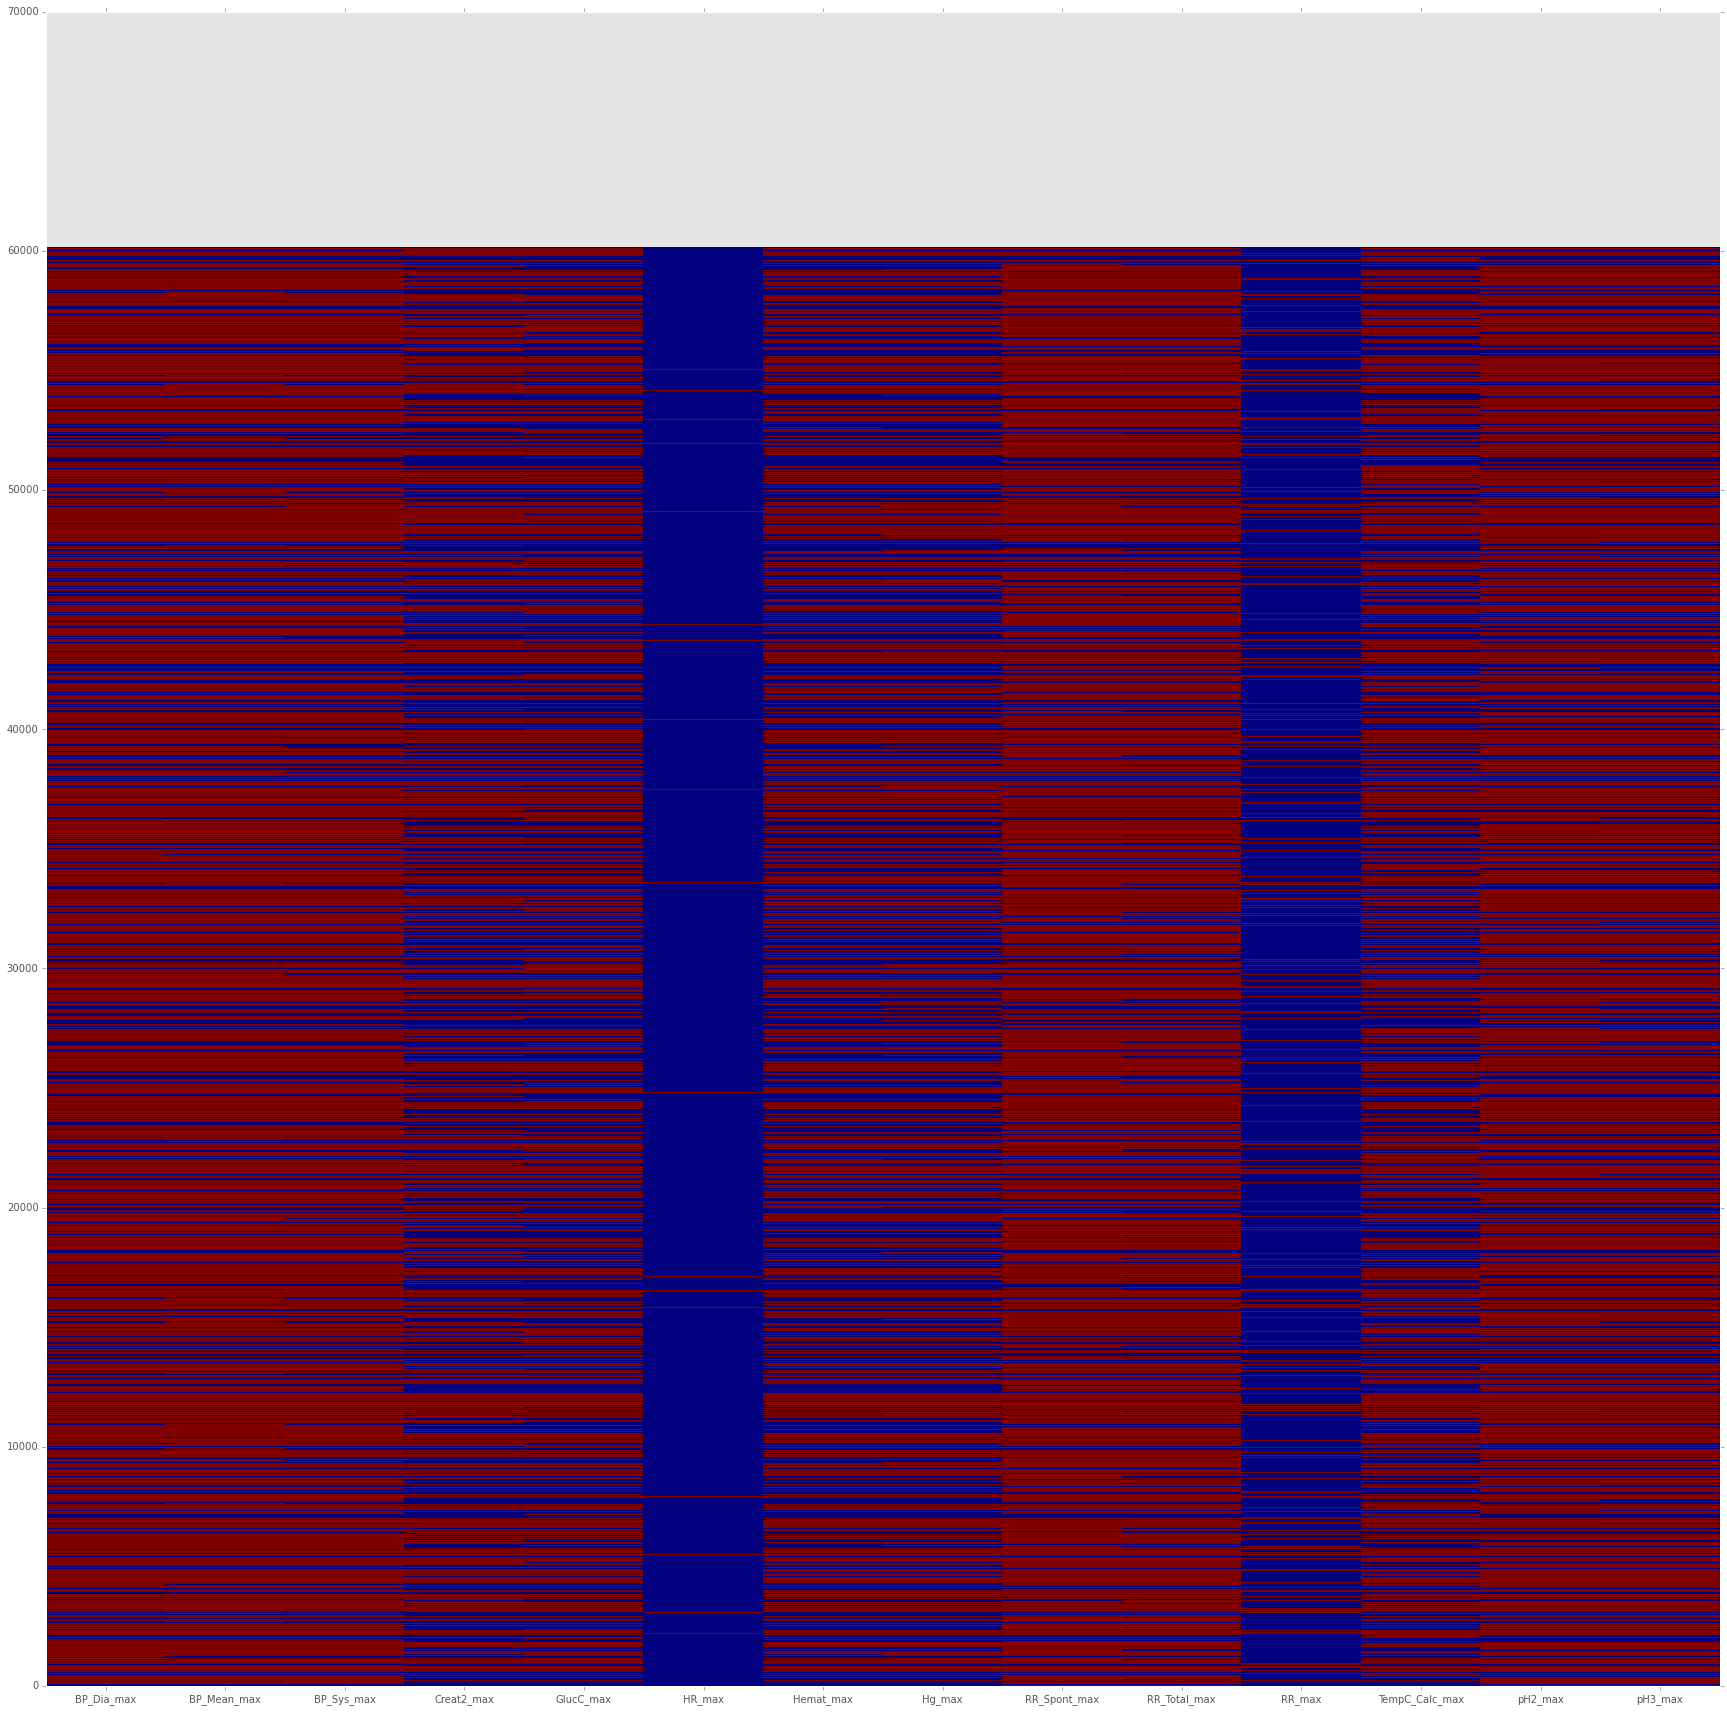

4504

,BP_Dia_first,BP_Mean_first,BP_Sys_first,Creat2_first,GlucC_first,HR_first,Hemat_first,Hg_first,RR_Spont_first,RR_Total_first,RR_first,TempC_Calc_first,pH2_first,pH3_first
BP_Dia_first,1.000000,0.969116,0.972770,0.555284,0.564235,NaN,0.585947,0.576272,0.648924,0.688134,NaN,0.410053,0.708454,0.744761
BP_Mean_first,0.969116,1.000000,0.972652,0.556777,0.565768,NaN,0.586548,0.576679,0.651559,0.689918,NaN,0.411231,0.711221,0.746947
BP_Sys_first,0.972770,0.972652,1.000000,0.558205,0.566578,NaN,0.588404,0.578463,0.654050,0.692502,NaN,0.413604,0.713256,0.749750
Creat2_first,0.555284,0.556777,0.558205,1.000000,0.847153,NaN,0.872821,0.861767,0.461583,0.512970,NaN,0.739716,0.554848,0.579663
GlucC_first,0.564235,0.565768,0.566578,0.847153,1.000000,NaN,0.927108,0.916929,0.463851,0.522678,NaN,0.793325,0.584831,0.609527
HR_first,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.433168,NaN,NaN,NaN
Hemat_first,0.585947,0.586548,0.588404,0.872821,0.927108,NaN,1.000000,0.972490,0.482367,0.542970,NaN,0.830930,0.604187,0.629862
Hg_first,0.576272,0.576679,0.578463,0.861767,0.916929,NaN,0.972490,1.000000,0.475450,0.535688,NaN,0.817586,0.604479,0.621757
RR_Spont_first,0.648924,0.651559,0.654050,0.461583,0.463851,NaN,0.482367,0.475450,1.000000,0.877541,NaN,NaN,0.655042,0.684614
RR_Total_first,0.688134,0.689918,0.692502,0.512970,0.522678,NaN,0.542970,0.535688,0.877541,1.000000,NaN,NaN,0.723425,0.757585


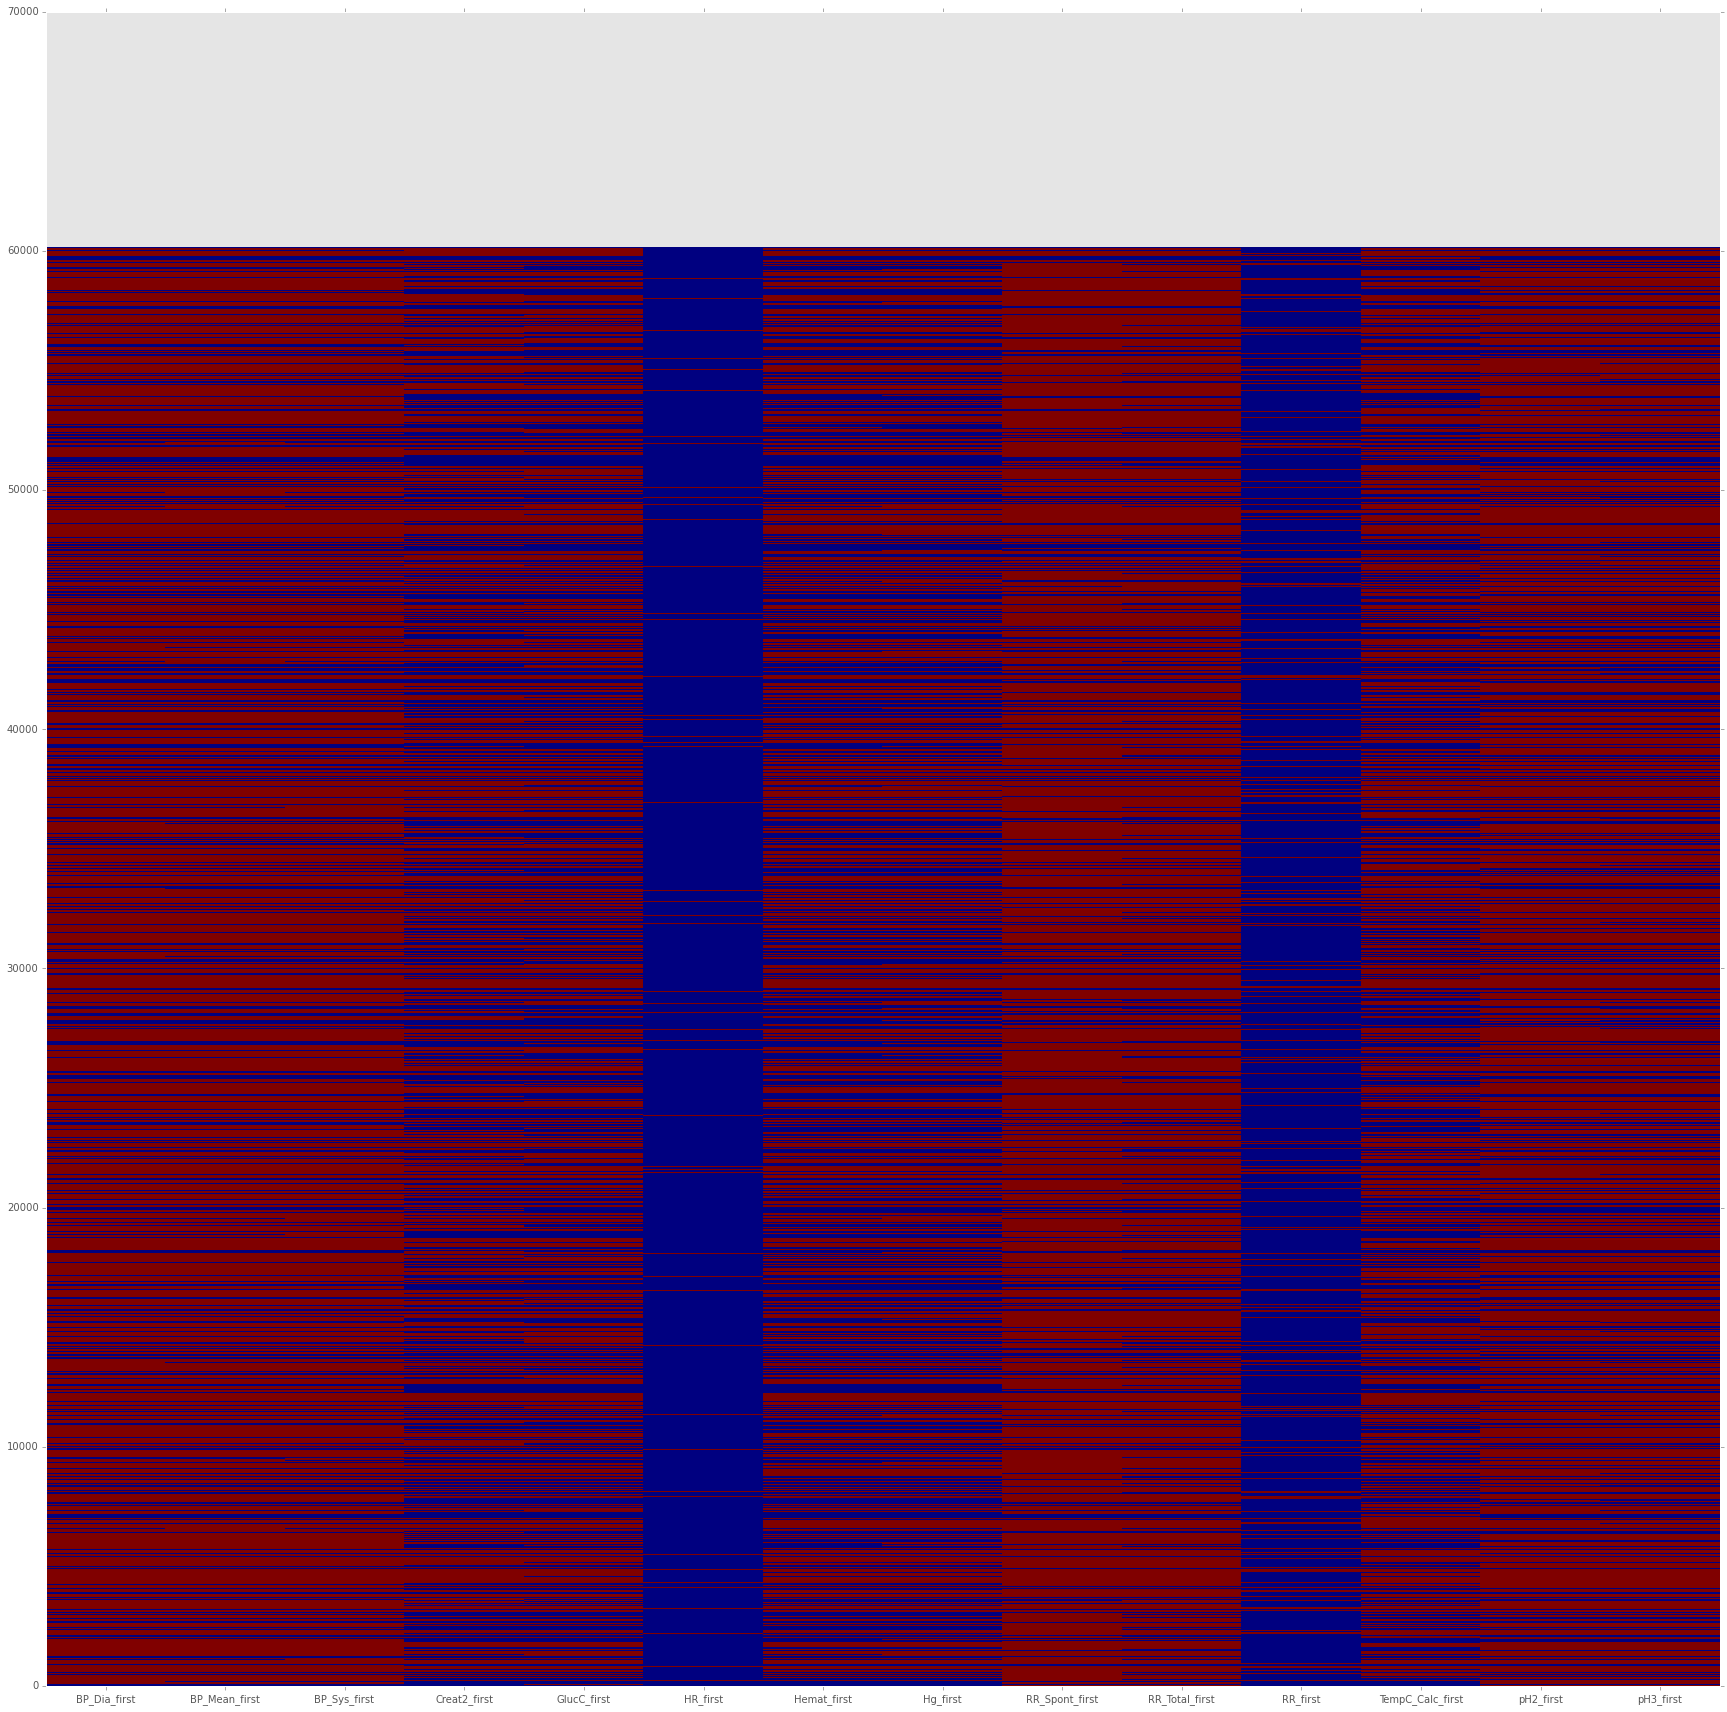

571

,BP_Dia_slope,BP_Mean_slope,BP_Sys_slope,Creat2_slope,GlucC_slope,HR_slope,Hemat_slope,Hg_slope,RR_Spont_slope,RR_Total_slope,RR_slope,TempC_Calc_slope,pH2_slope,pH3_slope
BP_Dia_slope,1.000000,0.783646,0.770192,0.452786,0.484444,NaN,0.454049,0.422591,0.463715,0.544535,NaN,NaN,0.619059,0.645475
BP_Mean_slope,0.783646,1.000000,0.786834,0.461880,0.495058,NaN,0.463483,0.430611,0.478300,0.557625,NaN,NaN,0.634387,0.662786
BP_Sys_slope,0.770192,0.786834,1.000000,0.450129,0.485773,NaN,0.452160,0.420799,0.460991,0.537610,NaN,NaN,0.615749,0.638533
Creat2_slope,0.452786,0.461880,0.450129,1.000000,0.731944,NaN,0.648546,0.694642,NaN,0.417921,NaN,0.457925,0.466326,0.465778
GlucC_slope,0.484444,0.495058,0.485773,0.731944,1.000000,NaN,0.655396,0.630150,NaN,0.438215,NaN,0.498720,0.480899,0.498979
HR_slope,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hemat_slope,0.454049,0.463483,0.452160,0.648546,0.655396,NaN,1.000000,0.727981,NaN,NaN,NaN,0.529739,0.434867,0.456416
Hg_slope,0.422591,0.430611,0.420799,0.694642,0.630150,NaN,0.727981,1.000000,NaN,NaN,NaN,0.434964,0.428552,0.430206
RR_Spont_slope,0.463715,0.478300,0.460991,NaN,NaN,NaN,NaN,NaN,1.000000,0.709646,NaN,NaN,0.517733,0.538330
RR_Total_slope,0.544535,0.557625,0.537610,0.417921,0.438215,NaN,NaN,NaN,0.709646,1.000000,NaN,NaN,0.633789,0.655504


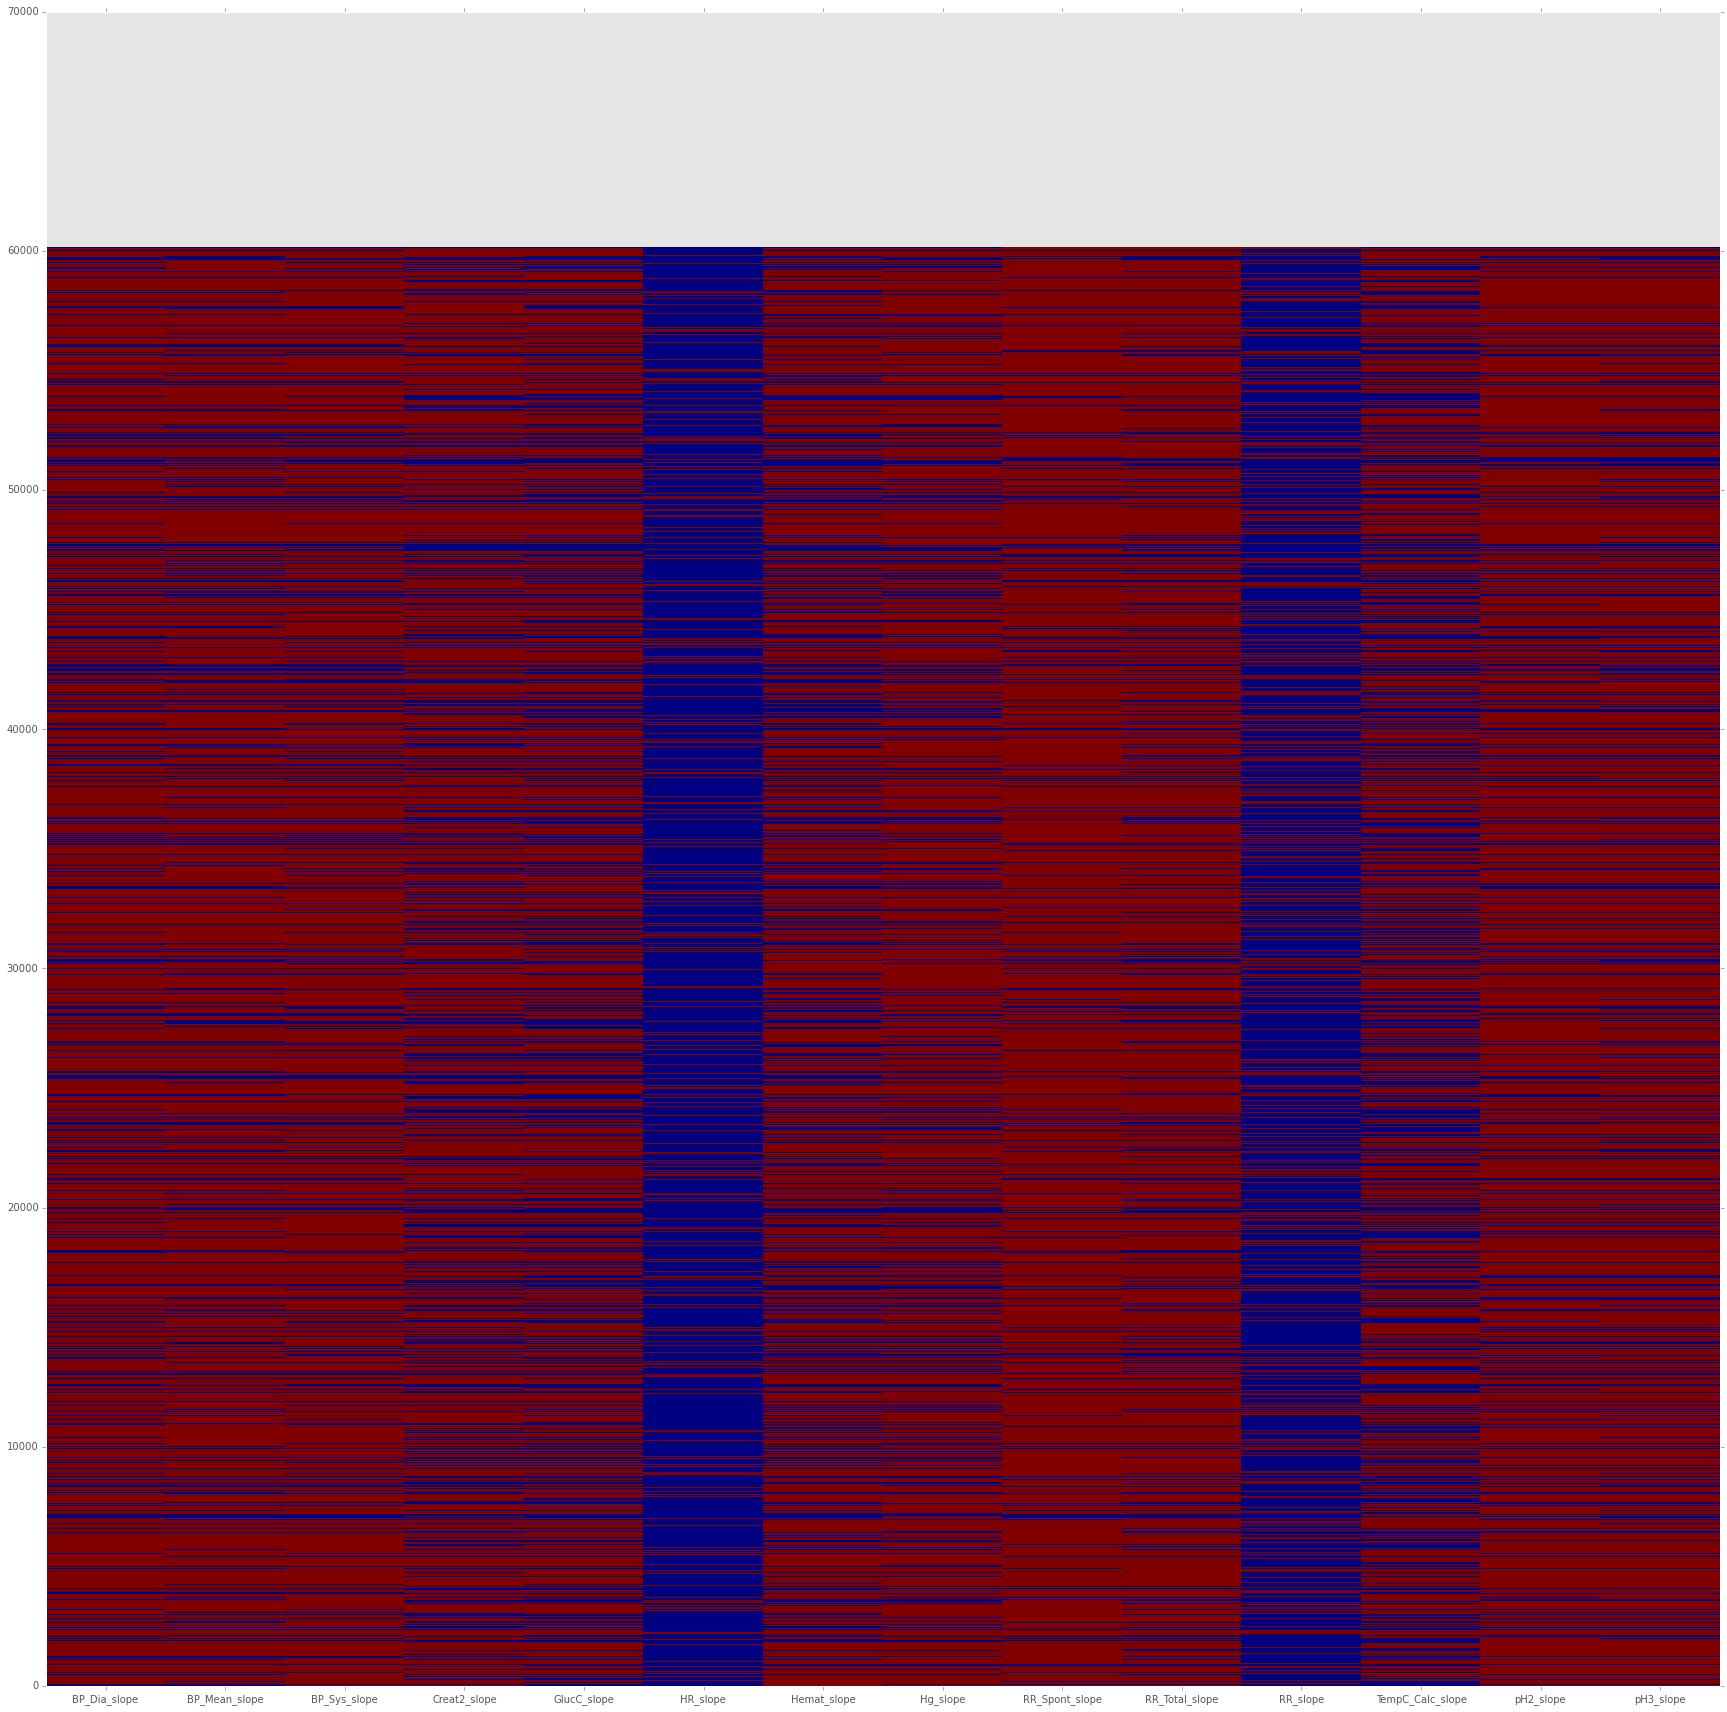

1948

,BP_Dia_delta,BP_Mean_delta,BP_Sys_delta,GlucC_delta,HR_delta,Hemat_delta,Hg_delta,RR_Total_delta,RR_delta,TempC_Calc_delta,pH2_delta,pH3_delta
BP_Dia_delta,1.000000,0.925824,0.931832,0.473996,NaN,0.466667,NaN,0.645584,NaN,NaN,0.654300,0.686251
BP_Mean_delta,0.925824,1.000000,0.929621,0.474527,NaN,0.463933,NaN,0.643024,NaN,NaN,0.652515,0.685377
BP_Sys_delta,0.931832,0.929621,1.000000,0.476213,NaN,0.466088,NaN,0.644283,NaN,NaN,0.652405,0.687231
GlucC_delta,0.473996,0.474527,0.476213,1.000000,NaN,0.765383,0.665393,0.431147,NaN,0.724038,0.488821,0.506327
HR_delta,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hemat_delta,0.466667,0.463933,0.466088,0.765383,NaN,1.000000,0.741042,0.420308,NaN,0.756482,0.485445,0.504014
Hg_delta,NaN,NaN,NaN,0.665393,NaN,0.741042,1.000000,NaN,NaN,0.650873,NaN,NaN
RR_Total_delta,0.645584,0.643024,0.644283,0.431147,NaN,0.420308,NaN,1.000000,NaN,NaN,0.658360,0.687849
RR_delta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
TempC_Calc_delta,NaN,NaN,NaN,0.724038,NaN,0.756482,0.650873,NaN,NaN,1.000000,0.409821,0.425893


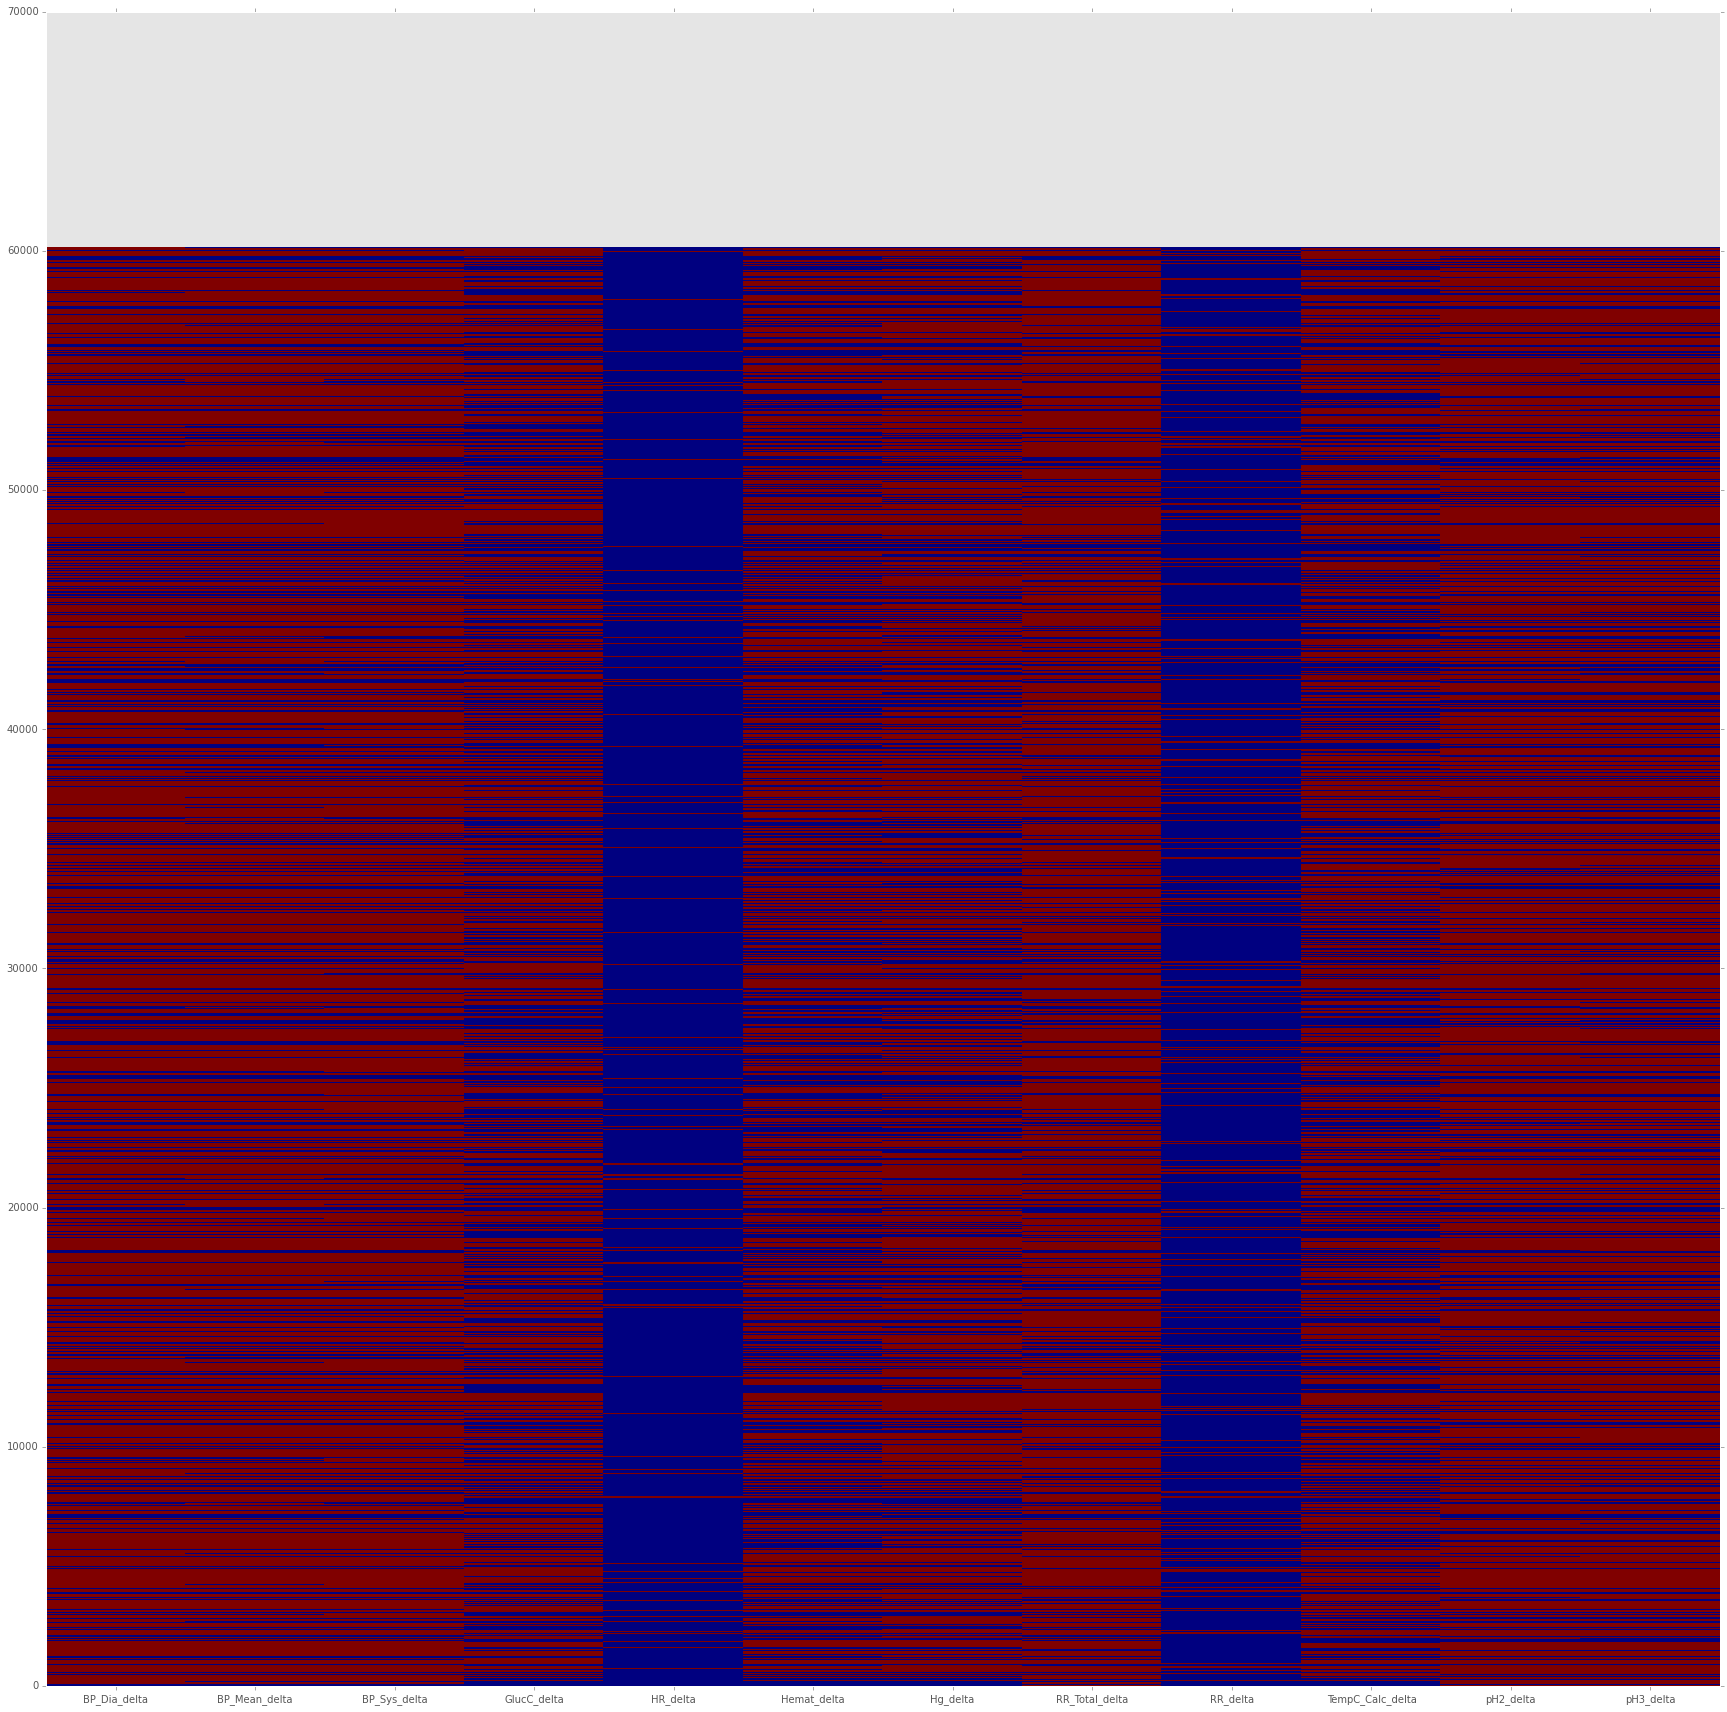

Complete


In [91]:
# DISPLAY COLORMAP OF DATA WHERE VALUES ARE TRANSFORMED TO 1 IF NAN, 0 OTHERWISE. 
# THIS SHOWS THE PRESENCE OF MISSING VALUES AND ENABLES US TO GET SOME IDEA ABOUT
# WHICH VARIABLES ARE MOST OFTEN PRESENT OR MISSING TOGETHER. ALSO DISPLAYING 
# CORRELATIN COEFFICIENTS BETWEEN MISSING VALUES 
calc_list = ['mean', 'med', 'std', 'skew', 'min', 'max', 'first', 'slope', 'delta']




for calc in calc_list:
    plt.figure(figsize= (30,30))
    cols = [x for x in data3.columns if calc in x] 
    cols.sort()
    
    header = data3[cols]
    for col in header.columns:
        max_val = -1000 #header[col].max()*100
        #header[col].replace(np.nan, max_val, inplace = True)
        header[col] = header[col].apply(lambda x: 1 if pd.isnull(x) else 0)
    display(data3[cols].dropna().shape[0])
    missing = header.corr()
    display(missing[missing >= 0.4])
    plt.pcolor(header)
    plt.xticks(np.arange(0.5, len(header.columns), 1), header.columns)
    plt.show()

print "Complete"

# BREAKING UP CONTINUOUS VARIABLES INTO AFFINITY GROUPS TO MAXIMIZE THE SAMPLES AVAILABLE FOR FEATURE SELECTION / EVALUATION

In [100]:
# BREAKING UP VARIABLES SO THAT WE CAN DROP NAN VALUES AND STILL HAVE SUFFICIENT SAMPLES 
# TO TRANSFORM AND DO FEATURE SELECTION / SCORING
# WILL NEED TO MERGE LATER IN A WAY THAT PROVIDES ADEQUATE SAMPLES

cols1 = [x for x in data3.columns if (('BP' in x) or ('pH' in x) or ('HR' in x))]
cols2 = [x for x in data3.columns if (('Creat2' in x) | ('Gluc' in x) | ('Hg' in x) | ('Hemat' in x) | ('TempC' in x))]
cols3 = [x for x in data3.columns if ('RR' in x)]
header = ['hospital_expire_flag', 'subject_id', 'icustay_id']
for thing in header:
    cols1.insert(0, thing)
    cols2.insert(0, thing) 
    cols3.insert(0, thing)

#display(cols1)
data3.replace([np.inf, -np.inf], np.nan, inplace = True)
cont_data1 = data3[cols1].dropna()
display(cont_data1.shape)
cont_data2 = data3[cols2].dropna()
display(cont_data2.shape)
cont_data3 = data3[cols3].dropna()
display(cont_data3.shape)

cont_frames = [cont_data1, cont_data2, cont_data3]

(2309, 57)

(874, 45)

(3654, 26)

In [103]:
cont_data3.head()

,icustay_id,subject_id,hospital_expire_flag,RR_Spont_first,RR_Spont_max,RR_Spont_mean,RR_Spont_med,RR_Spont_slope,RR_Spont_std,RR_Total_delta,...,RR_Total_std,RR_delta,RR_first,RR_max,RR_mean,RR_med,RR_min,RR_skew,RR_slope,RR_std
4,200009,29904,0,0.0,3.0,0.8,0.0,-0.321429,1.303840,-3.0,...,1.211060,1.0,15.0,22.0,16.161290,16.0,13.0,0.812483,-0.222222,2.310797
12,200019,21789,1,0.0,4.0,0.8,0.0,0.000000,1.788854,4.0,...,2.828427,-1.0,17.0,26.0,16.464286,16.0,12.0,1.943075,0.200000,2.603163
79,200117,5490,0,0.0,1.0,0.5,0.5,0.309278,0.707107,11.0,...,5.560276,-3.0,24.0,32.0,20.666667,20.0,10.0,-0.253033,0.375000,7.009025
91,200136,6338,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,2.0,10.0,23.0,12.444444,10.0,10.0,1.482310,0.500000,3.796084
106,200159,32704,0,7.0,7.0,2.5,1.0,-0.122449,3.146427,-1.0,...,4.454131,1.0,18.0,27.0,14.906977,14.0,7.0,0.545168,0.173913,4.602349


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x24bf48290>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x26c05afd0>]], dtype=object)

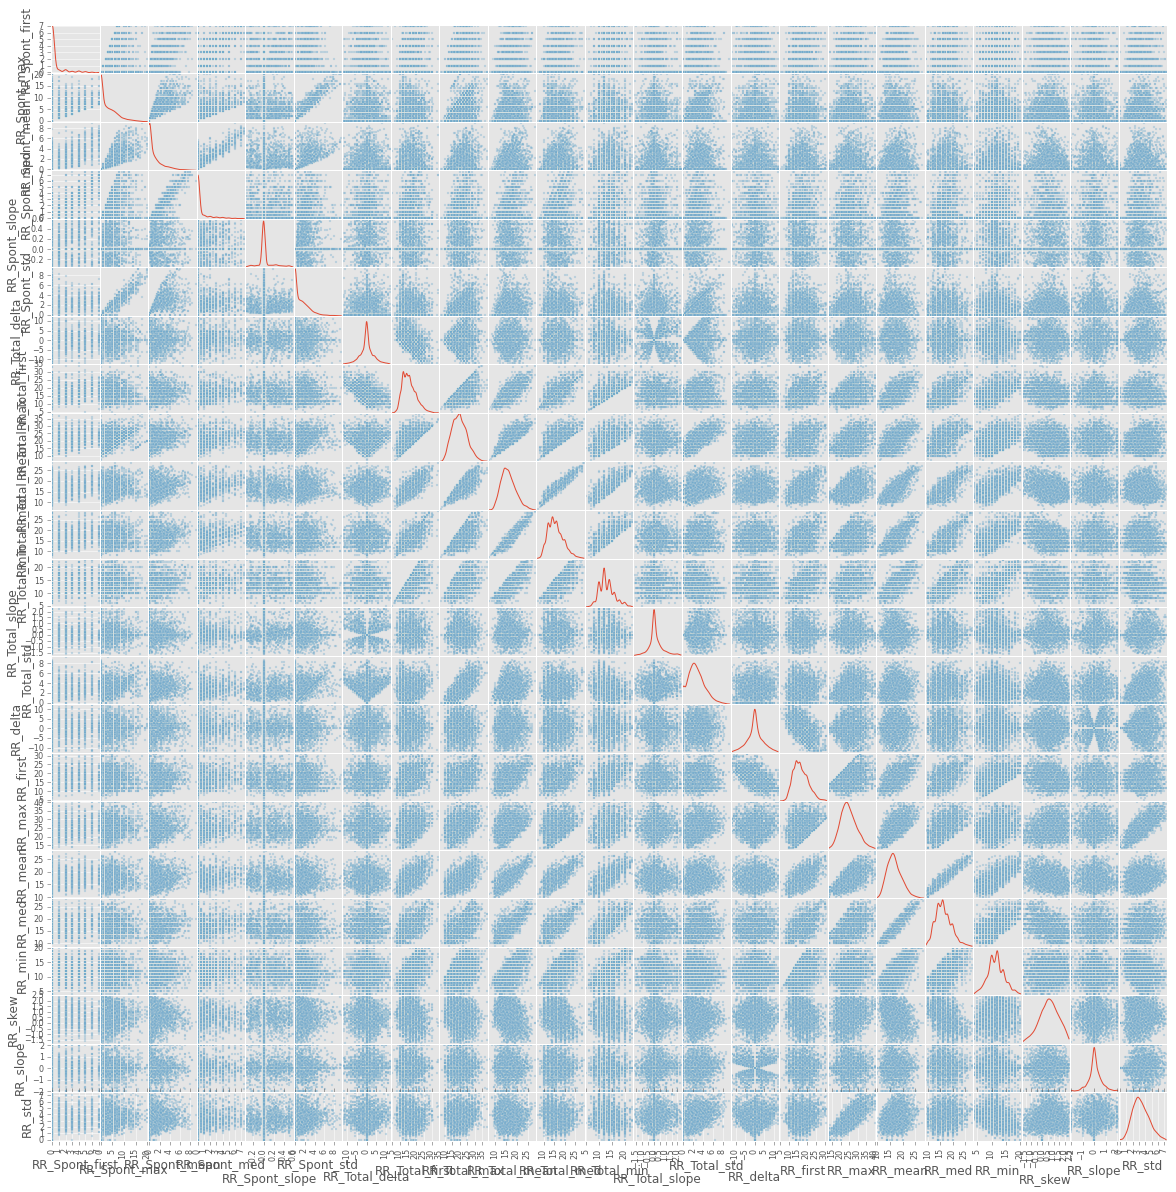

In [104]:
frame = cont_data3
pd.scatter_matrix(frame[frame.columns[3:]], alpha = 0.3, figsize = (20,20), diagonal = 'kde')
#for frame in cont_frames:
    #pd.scatter_matrix(frame[frame.columns[3:]], alpha = 0.3, figsize = (20,20), diagonal = 'kde');

In [107]:
# CALCULATING THE QUARTILES ON THE DISTRIBUTIONS AND BINNING DATA INTO 4 BUCKETS
# TO CONVERT CONTINUOUS VARIABLES TO CATEGORICAL

def quant_cats(feature, Q1, Q2, Q3):
    if feature <=Q1:
        return 'Q0'
    elif (feature >Q1 and feature <= Q2):
        return 'Q1'
    elif (feature > Q2 and feature <= Q3):
        return 'Q2'
    elif feature > Q3:
        return 'Q3'
    

cont_cat1 = cont_data1.copy()
cont_cat2 = cont_data2.copy()
cont_cat3 = cont_data3.copy()
cont_cat_frames = [cont_cat1, cont_cat2, cont_cat3]

for frame in cont_cat_frames:
    frame_stats = frame.describe()
    for col in frame.columns[3:]:
        Q1 = frame_stats[col].loc['25%']
        Q2 = frame_stats[col].loc['50%']
        Q3 = frame_stats[col].loc['75%']
        frame[col] = frame[col].apply(lambda x: quant_cats(x, Q1, Q2, Q3))

cont_cat1.head()        

'''

# CALCULATING THE QUARTILES ON THE DISTRIBUTIONS AND BINNING DATA INTO 4 BUCKETS
# TO CONVERT CONTINUOUS VARIABLES TO CATEGORICAL

def quant_cats(feature, Q1, Q2, Q3):
    if feature <=Q1:
        return 'Q0'
    elif (feature >Q1 and feature <= Q2):
        return 'Q1'
    elif (feature > Q2 and feature <= Q3):
        return 'Q2'
    elif feature > Q3:
        return 'Q3'
    

boxcox_data_cat = boxcox_data_scaled.copy()


for col in boxcox_data_scaled.columns[11:]:
    Q1 = boxcox_scaled_stats[col].loc['25%']
    Q2 = boxcox_scaled_stats[col].loc['50%']
    Q3 = boxcox_scaled_stats[col].loc['75%']
    boxcox_data_cat[col] = boxcox_data_scaled[col].apply(lambda x: quant_cats(x, Q1, Q2, Q3))
                                                    
'''
    

"\n\n# CALCULATING THE QUARTILES ON THE DISTRIBUTIONS AND BINNING DATA INTO 4 BUCKETS\n# TO CONVERT CONTINUOUS VARIABLES TO CATEGORICAL\n\ndef quant_cats(feature, Q1, Q2, Q3):\n    if feature <=Q1:\n        return 'Q0'\n    elif (feature >Q1 and feature <= Q2):\n        return 'Q1'\n    elif (feature > Q2 and feature <= Q3):\n        return 'Q2'\n    elif feature > Q3:\n        return 'Q3'\n    \n\nboxcox_data_cat = boxcox_data_scaled.copy()\n\n\nfor col in boxcox_data_scaled.columns[11:]:\n    Q1 = boxcox_scaled_stats[col].loc['25%']\n    Q2 = boxcox_scaled_stats[col].loc['50%']\n    Q3 = boxcox_scaled_stats[col].loc['75%']\n    boxcox_data_cat[col] = boxcox_data_scaled[col].apply(lambda x: quant_cats(x, Q1, Q2, Q3))\n                                                    \n"

In [119]:
display(cont_data1.describe().loc[['25%', '50%', '75%']])

display(cont_data1.head())
display(cont_cat1.head())

,icustay_id,subject_id,hospital_expire_flag,BP_Dia_delta,BP_Dia_first,BP_Dia_max,BP_Dia_mean,BP_Dia_med,BP_Dia_min,BP_Dia_skew,...,pH2_std,pH3_delta,pH3_first,pH3_max,pH3_mean,pH3_med,pH3_min,pH3_skew,pH3_slope,pH3_std
25%,225266.0,7816.0,0.0,-5.0,51.0,66.0,52.589744,52.0,40.0,-0.075918,...,0.025635,-0.03,7.34,7.40,7.350000,7.35,7.29,-0.680881,-0.003297,0.025635
50%,251101.0,16042.0,0.0,0.0,57.0,73.0,57.857143,57.0,45.0,0.330729,...,0.036794,0.00,7.38,7.43,7.381111,7.38,7.33,0.000000,0.000809,0.036794
75%,274703.0,24403.0,0.0,5.0,65.0,82.0,63.638889,63.0,51.0,0.741878,...,0.050000,0.03,7.42,7.47,7.412000,7.41,7.37,0.603570,0.005139,0.050000


,icustay_id,subject_id,hospital_expire_flag,BP_Dia_delta,BP_Dia_first,BP_Dia_max,BP_Dia_mean,BP_Dia_med,BP_Dia_min,BP_Dia_skew,...,pH2_std,pH3_delta,pH3_first,pH3_max,pH3_mean,pH3_med,pH3_min,pH3_skew,pH3_slope,pH3_std
4,200009,29904,0,-1.0,59.0,84.0,62.645161,57.0,49.0,0.868910,...,0.071063,-0.11,7.50,7.50,7.38000,7.39,7.29,0.360059,-0.014505,0.071063
44,200062,32092,0,5.0,68.0,92.0,68.358974,69.0,47.0,0.174540,...,0.031623,0.01,7.39,7.46,7.40500,7.40,7.37,0.722806,0.004724,0.031623
106,200159,32704,0,22.0,55.0,88.0,60.941176,58.0,49.0,0.970350,...,0.053968,-0.04,7.34,7.36,7.29375,7.30,7.19,-0.885583,-0.001982,0.053968
189,200300,19160,0,-13.0,71.0,71.0,58.000000,58.0,45.0,0.078931,...,0.043063,0.09,7.38,7.47,7.39100,7.38,7.34,0.770322,-0.014136,0.043063
202,200320,19582,0,3.0,49.0,58.0,52.250000,53.0,45.0,-0.419921,...,0.026458,-0.01,7.41,7.45,7.42000,7.41,7.40,1.457863,0.000958,0.026458


,icustay_id,subject_id,hospital_expire_flag,BP_Dia_delta,BP_Dia_first,BP_Dia_max,BP_Dia_mean,BP_Dia_med,BP_Dia_min,BP_Dia_skew,...,pH2_std,pH3_delta,pH3_first,pH3_max,pH3_mean,pH3_med,pH3_min,pH3_skew,pH3_slope,pH3_std
4,200009,29904,0,Q1,Q2,Q3,Q2,Q1,Q2,Q3,...,Q3,Q0,Q3,Q3,Q1,Q2,Q0,Q2,Q0,Q3
44,200062,32092,0,Q2,Q3,Q3,Q3,Q3,Q2,Q1,...,Q1,Q2,Q2,Q2,Q2,Q2,Q2,Q3,Q2,Q1
106,200159,32704,0,Q3,Q1,Q3,Q2,Q2,Q2,Q3,...,Q3,Q0,Q0,Q0,Q0,Q0,Q0,Q0,Q1,Q3
189,200300,19160,0,Q0,Q3,Q1,Q2,Q2,Q1,Q1,...,Q2,Q3,Q1,Q2,Q2,Q1,Q2,Q3,Q0,Q2
202,200320,19582,0,Q2,Q0,Q0,Q0,Q1,Q1,Q0,...,Q1,Q1,Q2,Q2,Q3,Q2,Q3,Q3,Q2,Q1


In [ ]:
'''
# TRANFORMS LIKE BOXCOX REQUIRE POSITIVE DATA SO WE'LL SHIFT DATA POSITIVE

below_zeros = list(cont_data3.columns[cont_data3.min() < 0])
for col in below_zeros:
    col_min = cont_data3[col].min()
    cont_data3.loc[:,col] = cont_data3[col].apply(lambda x: x-col_min)




col = 3

# create dict from which we'll build skew measures dataframe
skew_dict = {cont_data3.columns[col]:
              {
             'raw_skew': scats.skew(cont_data3[cont_data3.columns[col]].dropna()), 
             'sqrt_skew': scats.skew(np.sqrt(cont_data3[cont_data3.columns[col]].dropna())), 
             'log_skew': scats.skew(np.log(cont_data3[cont_data3.columns[col]].dropna().add(1))),  
             'boxcox_skew': scats.skew(scats.boxcox(cont_data3[cont_data3.columns[col]].dropna().add(1))[0])
             }
             }

print skew_dict
skew_df = pd.DataFrame.from_dict(skew_dict, orient = 'index')  
# re-order columns
skew_df = skew_df[['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew']]

for col in cont_data3.columns[3:]:
    raw_skew = scats.skew(cont_data3[col].dropna())
    
    sqrt_skew = scats.skew(np.sqrt(cont_data3[col].dropna()))
    log_skew = scats.skew(np.log(cont_data3[col].dropna().add(1)))
        #print "{} logskew = {}".format(col, new_skew_val2)
    boxcox_skew = scats.skew(scats.boxcox(cont_data3[col].dropna().add(1))[0])
    new_row = pd.Series([raw_skew, sqrt_skew, log_skew, boxcox_skew],
                        #index=['measurement', 'raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                        index=['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                       name = col)

    skew_df = skew_df.append(new_row)#, ignore_index = True)

skew_df.columns.name = 'Skewness Values'
skew_df.index.name = 'Lab Measures'
display(skew_df)

ax = skew_df.head(10).plot.bar(figsize = (20,7), title = 'Skewness Values for Different Data Transforms')
ax.set_ylabel("Skewness")


'''

In [ ]:
'''
#sqrt_norm_data = np.sqrt(data2_norm[data2_norm.columns[1:]])
#log_norm_data = np.log(data2_norm[data2_norm.columns[1:]].add(1))
boxcox_data = cont_data3.copy()



# BOXCOX CANNOT BE PERFORMED ON DATA W/ NAN'S. PREVIOUSLY DROPPED 
#boxcox_data.dropna(inplace = True)

# CONVERT FLAGS TO INT VALUES SO THAT I CAN TRANSFORM ONLY FLOAT
cols = skew_df[skew_df['raw_skew'] > 0.5].index

for col in cols:
    boxcox_data[col] = scats.boxcox(boxcox_data[col].add(1))[0]

pd.scatter_matrix(boxcox_data[boxcox_data.columns[3:]], alpha = 0.3, figsize = (20,20), diagonal = 'kde');
'''

In [ ]:
data4 = pd.DataFrame.from_csv('LAB_EVENTS_FIRST24_PROCESSED.csv')
data4.head()

In [ ]:
data3.set_index(['icustay_id'], inplace = True)
data4.set_index(['icustay_id'], inplace = True)
data4.drop('subject_id')

# ADD CODE TO LABEL LAB VS CHART CHART TIME
data3 = data3.merge(data4, left_index = True, right_index = True, 
                       how = 'left', sort = True, suffixes = ('_chart', '_lab'))

data3['icustay_id'] = data3.index
cols = list(data3.columns)
cols.sort()
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('subject_id')))
cols.insert(2, cols.pop(cols.index('Height')))
cols.insert(3, cols.pop(cols.index('Weight')))
cols.insert(4, cols.pop(cols.index('charttime_x')))
cols.insert(5, cols.pop(cols.index('charttime_y')))
cols.insert(6, cols.pop(cols.index('intime_x')))
cols.insert(7, cols.pop(cols.index('intime_y')))
cols.insert(8, cols.pop(cols.index('outtime_x')))
cols.insert(9, cols.pop(cols.index('outtime_y')))

data3 = data3[cols]
data3.set_index(np.arange(data3.shape[0]), inplace = True)

data3.head()

In [ ]:
data3.rename(columns = {'charttime_x':'charttime_chart', 'charttime_y':'charttime_lab', 
              'intime_x':'intime_chart', 'intime_y':'intime_lab', 
             'outtime_x':'outtime_chart', 'outtime_y':'outtime_lab'}, inplace = True)
data3.columns

In [ ]:
len(data3.columns)

In [ ]:
data4 = data3.dropna(thresh = 57)
data5 = data3.dropna(subset = ['BP_Dia_max'])

In [ ]:
for col in data5.columns:
    print "{} has  {} NaN values".format(col,data5[col].isnull().sum())

In [ ]:
data5.dropna(thresh = 50).head(10)

In [ ]:
for col in data4.columns:
    print "{} has  {} NaN values".format(col,data4[col].isnull().sum())

In [ ]:
#data3.drop(['admittime', 'intime', 'charttime', 'itemid', 'cgid', 'value', 
#            'valuenum', 'valueuom', 'label'], axis = 1, inplace = True)
#data3.drop(['itemid', 'angus'], axis = 1, inplace = True) 
#            'valuenum', 'valueuom', 'label'], axis = 1, inplace = True)

In [ ]:
display(data[(data.label=='WBC') & (data.valuenum.isnull())].head())

In [ ]:
print "CO        {}".format(CO_df.shape)
print "WBC       {}".format(WBC_df.shape)
print "RR        {}".format(RR_df.shape)
print "MAP       {}".format(MAP_df.shape)
print "HR        {}".format(HR_df.shape)
print "HR2       {}".format(HR2_df.shape)
print "CVP_med   {}".format(CVP_med_df.shape)
print "CVP_min   {}".format(CVP_min_df.shape)
print "pH        {}".format(pH_df.shape)
print "Lac_mean  {}".format(LAC_mean_df.shape)
print "Lac_min   {}".format(LAC_min_df.shape)

In [ ]:
ptnt_demog = pd.DataFrame.from_csv('PTNT_DEMOG_ANGUS_rev.csv')
ptnt_demog.shape

In [ ]:
display(data3.columns)
display(ptnt_demog.columns)

In [ ]:
ptnt_demog2 = ptnt_demog[['gender', 'marital_status', 'ethnicity', 'insurance', 'first_careunit', 
                          'age', 'hospital_expire_flag']]
ptnt_demog2.head()

## Merging the patient demographic and summary chart data

In [ ]:
data4 = data3.copy()
data4 = data4.merge(ptnt_demog2, left_index = True, right_index = True, how='left', sort = True)
data4.head()

In [ ]:
data4.isnull().sum()

In [ ]:
#df[np.isfinite(df['EPS'])]
#data4[np.isfinite(data4['CO_max'])].shape
#data5 = data4.drop(['CO_max', 'HR2_mean'], axis = 1)
# DROP COLUMNS WHERE THERE ARE (ARBITRARILY) < 7600 VALUES
data5 = data4[data4.columns[data4.isnull().sum() < 7600]]
data5.head()



In [ ]:
data5.dtypes

In [ ]:
float_vars = data5.dtypes[data5.dtypes == 'float'].index
cat_vars = data5.dtypes[data5.dtypes == 'object'].index
int_vars = data5.dtypes[data5.dtypes == 'int64'].index
cat_vars = cat_vars.drop(['value'])

In [ ]:
#int_vars = int_vars.drop(['subject_id', 'hospital_expire_flag', 'angus'])
#int_vars

In [ ]:
# HR2
display(data5.dropna().shape)
display(data5[data5.hospital_expire_flag == 1].dropna().shape)
display(data5[data5.hospital_expire_flag == 0].dropna().shape)

In [ ]:
for thing in cat_vars[1:2]:
    cats = list(data5[thing].unique())
    print cats

In [ ]:
for thing in cat_vars[:2]:
    datadict = dict()
    cats = list(data5[thing].unique())
    print thing
    print cats



In [ ]:
for thing in cat_vars:
    datadict = dict()
    cats = list(data5[thing].unique())
    print thing
    print cats

    for cat in cats:
        dead = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 1)].dropna().count()
        live = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 0)].dropna().count()
        total = float(live) + dead
        datadict[cat] = (live/total, dead/total)

    frame = pd.DataFrame.from_dict(datadict)
    frame.index = ['Survivors', 'Non_Survivors']
    
    frame.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                 alpha = 0.5, title = "Percent Survival Rate for " + thing)
    plt.show()


In [ ]:
len(int_vars)
int_vars[1:len(int_vars)-1]

In [ ]:
for thing in int_vars[1:len(int_vars)-1]:
    datadict = dict()
    cats = list(data5[thing].unique())
    print thing
    print cats

    for cat in cats:
        dead = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 1)].dropna().count()
        live = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 0)].dropna().count()
        #total = float(live) + dead
        #datadict[cat] = (live/total, dead/total)
        datadict[cat] = (live, dead)
    frame = pd.DataFrame.from_dict(datadict)
    frame.index = ['Survivors', 'Non_Survivors']
    
    frame.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                 alpha = 0.5, title = "Percent Survival Rate for " + thing)
    plt.show()


In [ ]:
float_vars

In [ ]:
for thing in float_vars:
    # plot
    plt.subplots(figsize=(13,6))
    data5[thing][data5.hospital_expire_flag==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival')
    data5[thing][data5.hospital_expire_flag==0].dropna().plot.kde(
        alpha=1.0,label='Survival')
    
  

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(thing.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(thing)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   # plt.xlim(0, data5[thing].dropna().quantile(0.99))
    
  

In [ ]:
dead_men = data5.gender[(data5['gender']=='M') & (data5.hospital_expire_flag ==1)].dropna().count()
dead_women = data5.gender[(data5['gender']=='F') & (data5.hospital_expire_flag ==1)].dropna().count()
live_men = data5.gender[(data5['gender']=='M') & (data5.hospital_expire_flag ==0)].dropna().count()
live_women = data5.gender[(data5['gender']=='F') & (data5.hospital_expire_flag ==0)].dropna().count()
survival = pd.DataFrame([[live_men, live_women], 
                        [dead_men, dead_women]], 
                       columns = ['Men', 'Women'],
                       index = ['Survivors', 'Non_Survivors'])
survival

In [ ]:
survival.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                             alpha = 0.5)

In [ ]:
np.arange(2)

In [ ]:
ind = np.arange(1,3)    # the x locations for the groups
width = 0.25       # the width of the bars: can also be len(x) sequence

plt.figure(figsize= (20,10))
p1 = plt.bar(ind - width/2, survival.iloc[0], width, color = 'green', edgecolor = 'black',
            linewidth = 3)
p2 = plt.bar(ind - width/2, survival.iloc[1], width, color = 'red', edgecolor = 'black', 
             linewidth = 3, bottom=survival.iloc[0])

plt.ylabel('Number of Patients')
plt.title('Survivors vs. Non-Survivors')
plt.xticks(ind, ('Men', 'Women'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Survivors', 'Non_Survivors'))

plt.show()

In [ ]:
#ax = skew_df.plot.bar(figsize = (20,7), title = 'Skewness Values for Different Data Transforms')
#ax.set_ylabel("Skewness")
#data5.groupby(['hospital_expire_flag'])[['gender']].count().plot(kind='bar', stacked = True )
data5[cat_vars].plot.hist()

In [ ]:
'''
# a dictionary is created containing units of measure for the different lab measurements
labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}
'''
# a list is created containing units of measure for the lab measurements
lab_units = ['g/dL',
        'mEq/L',
        'mEq/L',
        'mg/dL',
        '',
        'mEq/L',
        'mg/dL',
        'mg/dL',
        '%', 
        'g/dL',
        '',
        'mmol/L',
        'mmol/L',
        'mg/dL',
        'K/uL',
        'mEq/L',
        '',
        'sec',
        'mmol/L',
        '']

# currently using lab_measures and lab_units to create the dict. 
# could be done more succinctly using the dictionary described above
labs_dict = dict(zip(lab_measures, lab_units))
print labs_dict


In [ ]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_nonsurv = data[l][data.mort_icu==1].dropna().count()
    n_surv = data[l][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l][data.mort_icu==1].dropna().median()
    med_surv = data[l][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l][data.mort_icu==1].dropna().var()
    var_surv = data[l][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l][data.mort_icu==1].dropna().skew()
    skew_surv = data[l][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l][data.mort_icu==1].dropna(),
                              data[l][data.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    data[l][data.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l][data.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## Generating box-plots for each variable for both survival and non-survival groups. 

In [ ]:
# Plot first laboratory measurement on ICU admission vs ICU mortality
# Would be clearer to plot CDF
# Additional variables to be added: magnesium, phosphate, calcium

labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().count()
    n_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().median()
    med_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().var()
    var_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().skew()
    skew_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_1st'][data.mort_icu==1].dropna(),
                              data[l.lower()+'_1st'][data.mort_icu==0].dropna())

    # plot
    #fig, ax1 = plt.subplots(figsize=(13, 6))
    #fig.canvas.set_window_title('A Boxplot Example')
    #plt.subplots(figsize=(13,6))
    #box_data = data[['mort_icu', l.lower()+'_1st']].dropna()
    data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
    #data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
    #    label='Non-survival (n={})'.format(n_nonsurv))
    plt.suptitle("")
    '''
    data[l.lower()+'_1st'][data.mort_icu==0].dropna().plot.box(
        label='Survival (n={})'.format(n_surv))
    '''
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')
    
   # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   # plt.xlim(0, data[l.lower()+'_1st'].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
    
    

## From the density plots above, a list of variables was generated for which the distribution was very similar between survival and non-survival groups. (Maybe include similarity threshold??)

In [ ]:
# Generate list of variables which, from density plots above, are similar between surivial and non-survival groups
cols_list = list(data.columns)
remove_list = ['chloride_1st', 'glucose_1st', 'hematocrit_1st', 'hemoglobin_1st', 'platelet_1st']
for element in remove_list:
    cols_list.remove(element)
    
display(cols_list)

In [ ]:
# data4 includes all variables except those identified as similar between survival and non-survival groups. 
data2 = data[cols_list]
data2.head()

## Removing data points that include any NaN values

In [ ]:
# remove samples which have any values that are nan
data2 = data2.dropna()
data2.set_index(np.arange(data2.shape[0]), inplace = True)
data2.head()

## The survival rate calculated below indicates that 82% of patients survived. 

In [ ]:
dead = data2['mort_icu'][data2.mort_icu==1].count()
survivors = data2['mort_icu'][data2.mort_icu==0].count()
survival_rate = float(survivors)/(dead+survivors)
print "Number of  patients deceased = {}".format(dead)
print "Number of patients           = {}".format(dead + survivors)
print "Survival Rate                = {}".format(survival_rate * 100)

## Support Vector Machine Classification on un-processed data with variables selected based on visual inspection
The variables enumerated in 'remove_list' were observed for both survivors and non-survivors and appeared to be very similar in distribution. Because they appeared to be very similar for both groups, they were excluded as features for classification. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.30, random_state = 42)

clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, data2[data2.columns[1:]], data2['mort_icu'], cv=5)
display(scores)  


In [ ]:
clf_SVC.score(X_test, y_test)
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

## The Confusion Matrix indicates that the classifier simply predicts survival for each patient which, because 82% of the patients survived, results in 82% Accuracy. 

## Gaussian Naive Bayes Classification on un-processed data with variables selected based on visual inspection

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.40, random_state = 42)

### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)



## The Confusion Matrix indicates that the classifier predicts survival rates with ~78% accuracy with a mixture of predictions rather than predicting all survival as was the case for the SVM classifier. Unfortunately, the accuracy is not better than predicting all survivors. 

## Multi-Layer Perceptron Classification on un-processed data with variables selected based on visual inspection

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.20, random_state = 42)

clf_MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(7, 4), random_state=1)

clf_MLP.fit(X_train, y_train)                         

display(clf_MLP.score(X_test, y_test))
y_predsMLP = clf_MLP.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)




## Creating a Dataframe of skewness measurements for the raw data and for different transforms to calculate what transform does the best job of normalizing the data

In [ ]:
# create dict from which we'll build skew measures dataframe
skew_dict2 = {data2.columns[1]:
              {
             'raw_skew': scats.skew(data2[data2.columns[1]]), 
             'sqrt_skew': scats.skew(np.sqrt(data2[data2.columns[1]])), 
             'log_skew': scats.skew(np.log(data2[data2.columns[1]].add(1))),  
             'boxcox_skew': scats.skew(scats.boxcox(data2[data2.columns[1]].add(1))[0])
             }
             }

print skew_dict2
skew_df = pd.DataFrame.from_dict(skew_dict2, orient = 'index')  
skew_df

In [ ]:
# re-order columns
skew_df = skew_df[['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew']]


In [ ]:
skew_df

In [ ]:
              
for col in data2.columns[2:]:
    raw_skew = scats.skew(data2[col])
    
    sqrt_skew = scats.skew(np.sqrt(data2[col]))
    log_skew = scats.skew(np.log(data2[col].add(1)))
        #print "{} logskew = {}".format(col, new_skew_val2)
    boxcox_skew = scats.skew(scats.boxcox(data2[col].add(1))[0])
    new_row = pd.Series([raw_skew, sqrt_skew, log_skew, boxcox_skew],
                        #index=['measurement', 'raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                        index=['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                       name = col)

    skew_df = skew_df.append(new_row)#, ignore_index = True)

skew_df

In [ ]:
skew_df.columns.name = 'Skewness Values'
skew_df.index.name = 'Lab Measures'

## The figure below shows the skewness values for each lab measurement for normalized data that has been transformed by taking the log, the square root and using the box-cox function. It can be seen that the box-cox function performed better than other transforms in reducing skewness. 


In [ ]:
ax = skew_df.plot.bar(figsize = (20,7), title = 'Skewness Values for Different Data Transforms')
ax.set_ylabel("Skewness")

In [ ]:
#sqrt_norm_data = np.sqrt(data2_norm[data2_norm.columns[1:]])
#log_norm_data = np.log(data2_norm[data2_norm.columns[1:]].add(1))
boxcox_data = data2.copy()
for feature_name in data2.columns[1:]:
    boxcox_data[feature_name] = scats.boxcox(data2[feature_name].add(1))[0]

boxcox_data.head()

## Code to identify outliers in normalized data

In [ ]:
names_dict = {}
suffix = '_outliers'


for feature in boxcox_data.cols():
    if feature != 'mort_icu':
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(boxcox_data[feature], 25)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(boxcox_data[feature], 75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)

        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        names_dict[feature+suffix] = boxcox_data[~((boxcox_data[feature] >= Q1 - step) & (boxcox_data[feature] <= Q3 + step))].index
# OPTIONAL: Select the indices for data points you wish to remove

## Code to remove datapoints from normalized data with 3 or more variables that are outliers

In [ ]:
all_outliers = []
for feature in names_dict.cols():
    all_outliers.extend(names_dict[feature])
print "the total outlier indices = {}".format(len(all_outliers))
indices, counts = np.unique(all_outliers, return_counts = True)
outlier_dict = {'counts': counts,
                'indices': indices
               }
outlier_df = pd.DataFrame(outlier_dict)

outliers  = list(outlier_df[outlier_df.counts >= 2].indices.values)
print "the following data points have >2 outlying feature and will be removed: \n{}".format(outliers)
# Remove the outliers, if any were specified


boxcox_data2 = boxcox_data.drop(boxcox_data.index[outliers]).reset_index(drop = True)

In [ ]:

# I believe this can be done more efficiently with sklearn.preprocessing.scale
boxcox_data_scaled = boxcox_data2.copy()
for feature_name in boxcox_data2.columns[1:]:
#    max_value = data2[feature_name].max()
#    min_value = data2[feature_name].min()
#    data2_norm[feature_name] = (data2[feature_name] - min_value) / (max_value - min_value)
    boxcox_data_scaled[feature_name] = preprocessing.scale(boxcox_data_scaled[feature_name], with_mean = True, 
                                                  with_std = True)
    
display(boxcox_data_scaled.head())
display(boxcox_data.head())


In [ ]:
#remove_list

In [ ]:
'''
# a dictionary is created containing units of measure for the different lab measurements
labs_dict2 = labs_dict

# could be done more succinctly using the dictionary described above

for item in remove_list:
    del labs_dict2[item]

print labs_dict2
print boxcox_data_scaled.columns

import collections
labs_dict3 = collections.OrderedDict(sorted(labs_dict2.items()))
labs_dict3
'''

## Plotting frequency distribution for each lab measurement for both survival and non-survival groups. 

In [ ]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().count()
    n_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().median()
    med_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().median()
    var_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().var()
    var_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().var()
    skew_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().skew()
    skew_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna(),
                              boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    #plt.xlim(0, boxcox_data_scaled[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## Performing PCA on box-cox transformed, scaled data with outliers removed

In [ ]:
# principle component analysis is used to reduce the dimensionality of data

#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 4).fit(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], pca)


In [ ]:
reduced_data = pca.transform(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']) #,
                                                    #'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
reduced_data.head()

## Scatterplot of Box-Cox transformed data with outliers removed. 

In [ ]:
pd.scatter_matrix(boxcox_data_scaled[1:], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## Normalized data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

In [ ]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(reduced_data, 
                                                    boxcox_data_scaled['mort_icu'], test_size = .30, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)


## Box-Cox transformed data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

## Neural Network Classifier was trained and tested using principle components of normalized data .

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], 
                                                    boxcox_data_scaled['mort_icu'], test_size = 0.40, random_state = 42)


clf = MLPClassifier(solver='sgd', alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)



In [ ]:
data[data.columns[5:]].head()

## Neural Network Classifier was trained and tested using principle components of normalized data .

In [ ]:
boxcox_dead = boxcox_data_scaled[boxcox_data_scaled.mort_icu == 1]
boxcox_survivors = boxcox_data_scaled[boxcox_data_scaled.mort_icu == 0]
display(boxcox_dead.shape[0])
display(boxcox_survivors.shape[0])
boxcox_survivors_reduced = boxcox_survivors.sample(boxcox_dead.shape[0])
frames = [boxcox_survivors_reduced, boxcox_dead]
boxcox_even = pd.concat(frames)
boxcox_even.shape

In [ ]:
num_samps = boxcox_even.shape[0]
display(num_samps)

boxcox_even2 = boxcox_even.sample(n=num_samps)
#boxcox_even2.shape()
boxcox_even2.shape

In [ ]:
boxcox_even2.head(10)

In [ ]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.40, 
                                                    random_state = 42)

### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)


## Support Vector Machine Classification on un-processed data with variables selected based on visual inspection
The variables enumerated in 'remove_list' were observed for both survivors and non-survivors and appeared to be very similar in distribution. Because they appeared to be very similar for both groups, they were excluded as features for classification. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.30, 
                                                    random_state = 42)



clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, boxcox_data_scaled[boxcox_data_scaled.columns[1:]], 
                         boxcox_data_scaled['mort_icu'], cv=5)
display(scores)  
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

In [ ]:
display(clf_SVC.score(X_test, y_test))
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.30, 
                                                    random_state = 42)

clf = MLPClassifier(solver='sgd', alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)



In [ ]:
print "moncol"

In [ ]:
diagnoses_codes = pd.DataFrame.from_csv('IDC9_DEADLY_DIAGNOSES.csv')
diagnoses_codes.head()

In [ ]:
diagnoses_list = diagnoses_codes.icd9_code.unique()
diagnoses_list2 = diagnoses_codes.diagnosis.unique()
display(len(diagnoses_list))
display(len(diagnoses_list2))

In [ ]:
unique_codes = diagnoses_codes.drop_duplicates(['icd9_code', 'short_title'])
unique_codes.shape


In [ ]:
unique_codes.head()

In [ ]:
len(diagnoses_list)

In [ ]:
diag_counts = diagnoses_codes.icd9_code.value_counts()

In [ ]:
diag_counts[0:10]

In [ ]:
diagnoses_list[0:10]

In [ ]:
boxcox_data_scaled.columns

In [ ]:
boxcox_data_scaled_subset = boxcox_data_scaled[['mort_icu', 'albumin_1st', 'bicarbonate_1st', 'inr_1st', 'phosphate_1st',
                                                'ptt_1st']]
boxcox_data_scaled_subset.head()

In [ ]:
# principle component analysis is used to reduce the dimensionality of data

#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 3).fit(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], pca)


In [ ]:
reduced_data = pca.transform(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']) #,
                                                    #'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
reduced_data.head()

## Scatterplot of Box-Cox transformed data with outliers removed. 

## Normalized data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

In [ ]:
feat_list = list(boxcox_data_scaled_subset.columns[1:])
feat_list

In [ ]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(boxcox_data_scaled_subset[feat_list], 
                                                    boxcox_data_scaled_subset['mort_icu'], 
                                                    test_size = .30, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)
